Loading datasets...
Train shape: (750000, 9)
Test shape: (250000, 8)

First five rows of the training set:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0



Checking for missing values:
No missing values found in training set.


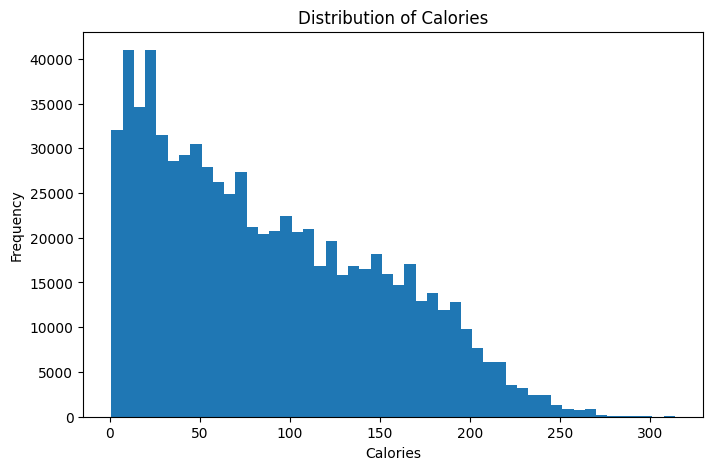


Generating histograms for each numeric feature...


Feature histograms:   0%|          | 0/6 [00:00<?, ?it/s]

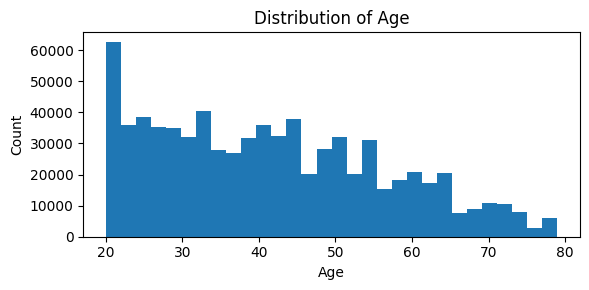

Feature histograms:  17%|█▋        | 1/6 [00:00<00:01,  4.56it/s]

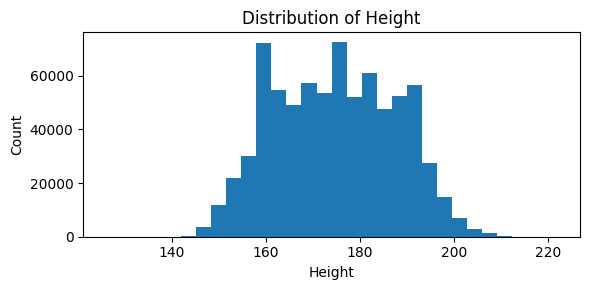

Feature histograms:  33%|███▎      | 2/6 [00:00<00:00,  4.36it/s]

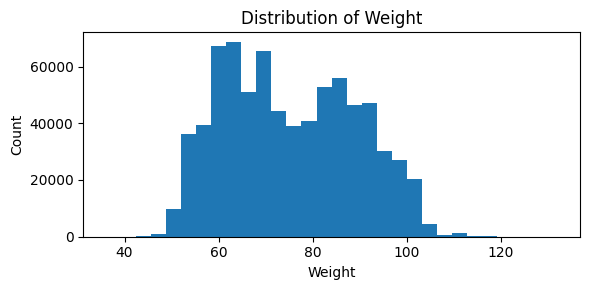

Feature histograms:  50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

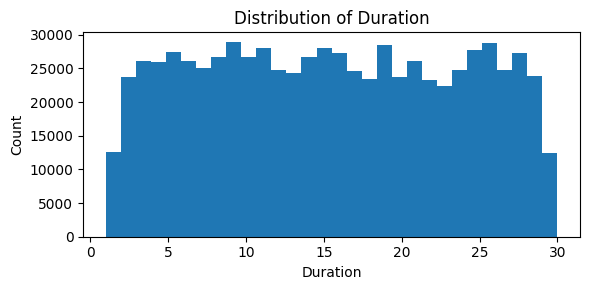

Feature histograms:  67%|██████▋   | 4/6 [00:01<00:00,  3.43it/s]

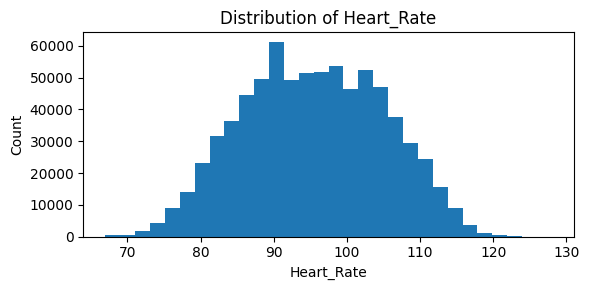

Feature histograms:  83%|████████▎ | 5/6 [00:01<00:00,  2.84it/s]

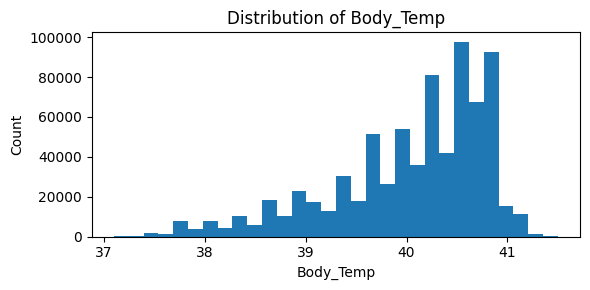

Feature histograms: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]



Computing correlation matrix and plotting heatmap...


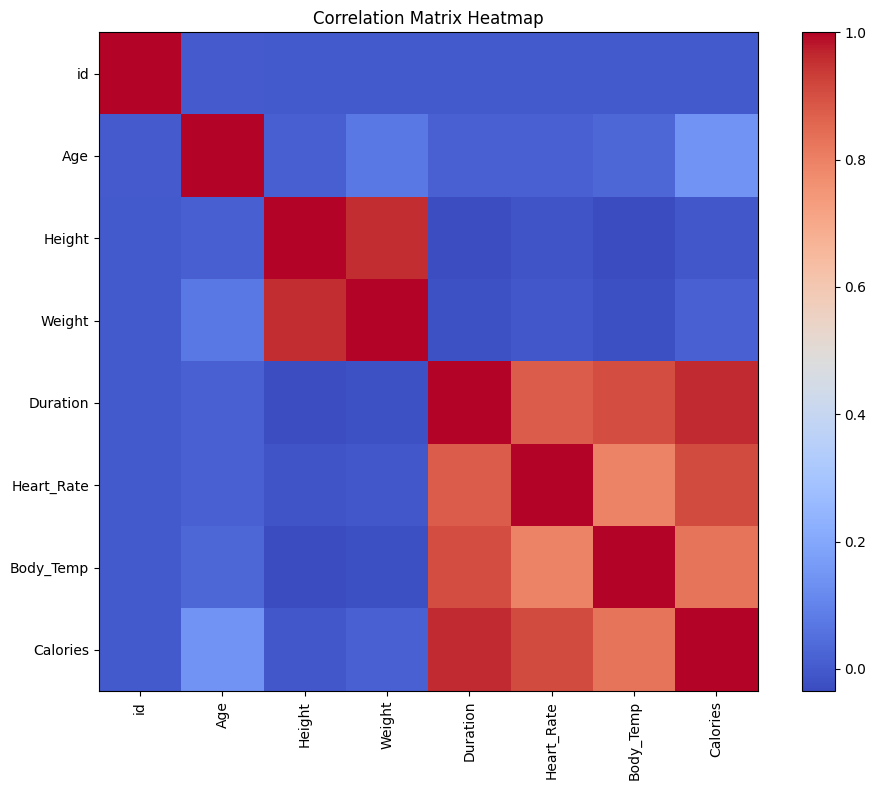


Summary statistics of training set:


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure plots render inline
%matplotlib inline

# Step 1: Load the training and test datasets
print("Loading datasets...")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Step 2: Display first few rows of training data for a quick glance
print("\nFirst five rows of the training set:")
display(train.head())

# Step 3: Check for missing values in training data
print("\nChecking for missing values:")
missing = train.isnull().sum()
missing = missing[missing > 0].to_frame(name='missing_count')
if missing.empty:
    print("No missing values found in training set.")
else:
    display(missing)

# Step 4: Distribution of the target variable (Calories)
plt.figure(figsize=(8, 5))
plt.hist(train['Calories'], bins=50)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

# Step 5: Histograms of numeric features with progress bar
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('Calories')  # Exclude target
if 'id' in numeric_features:
    numeric_features.remove('id')  # Exclude identifier if present

print("\nGenerating histograms for each numeric feature...")
for feature in tqdm(numeric_features, desc="Feature histograms"):
    plt.figure(figsize=(6, 3))
    plt.hist(train[feature], bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Step 6: Correlation matrix heatmap
print("\nComputing correlation matrix and plotting heatmap...")
# Select only numeric features for correlation
numeric_df = train.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Step 7: Summary statistics for reference
print("\nSummary statistics of training set:")
display(train.describe())


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

def simple_feature_engineering(df):
    """Create basic engineered features"""
    df = df.copy()

    # Encode Sex
    le = LabelEncoder()
    df['Sex_encoded'] = le.fit_transform(df['Sex'])

    # Basic features
    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    df['Max_HR'] = 220 - df['Age']
    df['HR_Percentage'] = df['Heart_Rate'] / df['Max_HR']

    # Interaction features
    df['Weight_Duration'] = df['Weight'] * df['Duration']
    df['HR_Duration'] = df['Heart_Rate'] * df['Duration']

    # Drop original Sex column
    df = df.drop(['Sex'], axis=1)

    return df, le

def train_and_predict():
    """Simple training and prediction pipeline"""
    print("Loading data...")
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    # Feature engineering
    print("Engineering features...")
    X_train_eng, label_encoder = simple_feature_engineering(train_df.drop('Calories', axis=1))

    # Apply same encoding to test data
    test_df_copy = test_df.copy()
    test_df_copy['Sex_encoded'] = label_encoder.transform(test_df_copy['Sex'])
    X_test_eng, _ = simple_feature_engineering(test_df_copy)

    y_train = train_df['Calories']

    # Split for validation
    X_train, X_val, y_train_split, y_val = train_test_split(
        X_train_eng, y_train, test_size=0.2, random_state=42
    )

    print(f"Training features: {X_train.shape[1]}")

    # Train Random Forest
    print("Training Random Forest...")
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train_split)
    rf_pred = rf_model.predict(X_val)
    rf_mae = mean_absolute_error(y_val, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))

    print(f"Random Forest - MAE: {rf_mae:.3f}, RMSE: {rf_rmse:.3f}")

    # Train XGBoost
    print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    xgb_model.fit(X_train, y_train_split)
    xgb_pred = xgb_model.predict(X_val)
    xgb_mae = mean_absolute_error(y_val, xgb_pred)
    xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))

    print(f"XGBoost - MAE: {xgb_mae:.3f}, RMSE: {xgb_rmse:.3f}")

    # Create ensemble predictions
    print("Creating ensemble predictions...")
    rf_test_pred = rf_model.predict(X_test_eng)
    xgb_test_pred = xgb_model.predict(X_test_eng)

    # Simple average ensemble
    ensemble_pred = (rf_test_pred + xgb_test_pred) / 2

    # Create submission
    sample_submission['Calories'] = ensemble_pred
    sample_submission.to_csv('simple_submission.csv', index=False)

    print(f"\nSubmission created!")
    print(f"Predictions - Min: {ensemble_pred.min():.2f}, Max: {ensemble_pred.max():.2f}, Mean: {ensemble_pred.mean():.2f}")

    # Feature importance
    print("\nTop 10 Most Important Features (Random Forest):")
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(10))

    return sample_submission

if __name__ == "__main__":
    submission = train_and_predict()
    print("\nDone! Check 'simple_submission.csv' for your submission file.")

Loading data...
Train shape: (750000, 9)
Test shape: (250000, 8)
Engineering features...
Training features: 13
Training Random Forest...
Random Forest - MAE: 2.181, RMSE: 3.677
Training XGBoost...
XGBoost - MAE: 2.193, RMSE: 3.630
Creating ensemble predictions...

Submission created!
Predictions - Min: 1.05, Max: 304.27, Mean: 88.25

Top 10 Most Important Features (Random Forest):
            feature  importance
12      HR_Duration    0.957306
10    HR_Percentage    0.033186
7       Sex_encoded    0.005734
11  Weight_Duration    0.001834
3            Weight    0.000588
5        Heart_Rate    0.000380
2            Height    0.000269
8               BMI    0.000162
0                id    0.000161
6         Body_Temp    0.000134

Done! Check 'simple_submission.csv' for your submission file.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

def advanced_feature_engineering(df, is_train=True, label_encoder=None):
    """Advanced feature engineering with proper scaling"""
    df = df.copy()

    # Remove ID from features (CRITICAL FIX)
    if 'id' in df.columns:
        df = df.drop(['id'], axis=1)

    # Encode Sex properly
    if is_train:
        if label_encoder is None:
            label_encoder = LabelEncoder()
        df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])
    else:
        df['Sex_encoded'] = label_encoder.transform(df['Sex'])

    # Core physiological features
    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    df['BSA'] = 0.007184 * (df['Weight'] ** 0.425) * (df['Height'] ** 0.725)  # Body Surface Area

    # Heart Rate Zones (more nuanced)
    df['Max_HR'] = 220 - df['Age']
    df['Resting_HR'] = df['Max_HR'] * 0.6  # Estimated resting HR
    df['HR_Reserve'] = df['Heart_Rate'] - df['Resting_HR']
    df['HR_Reserve'] = np.maximum(df['HR_Reserve'], 0)  # Can't be negative
    df['HR_Percentage'] = df['Heart_Rate'] / df['Max_HR']

    # Exercise Intensity Zones
    conditions = [
        (df['HR_Percentage'] <= 0.6),
        (df['HR_Percentage'] <= 0.7),
        (df['HR_Percentage'] <= 0.8),
        (df['HR_Percentage'] <= 0.9),
        (df['HR_Percentage'] > 0.9)
    ]
    choices = [1, 2, 3, 4, 5]  # Light, Moderate, Vigorous, Hard, Maximum
    df['Intensity_Zone'] = np.select(conditions, choices, default=3)

    # Metabolic Equivalent (METs) estimation
    df['METs'] = 1 + (df['HR_Reserve'] / (df['Max_HR'] * 0.4)) * 12
    df['METs'] = np.clip(df['METs'], 1, 18)  # Realistic MET range

    # Basal Metabolic Rate (BMR) - Mifflin-St Jeor
    bmr_male = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] + 5
    bmr_female = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] - 161
    df['BMR'] = np.where(df['Sex'] == 'male', bmr_male, bmr_female)

    # Temperature-based features
    df['Temp_Normal'] = abs(df['Body_Temp'] - 37.0)
    df['Temp_Factor'] = 1 + (df['Body_Temp'] - 37) * 0.07  # Each degree affects metabolism

    # Age-based metabolism
    df['Age_Factor'] = np.maximum(0.7, 1 - (df['Age'] - 25) * 0.005)  # Metabolism decreases with age

    # Calorie burn rate (per minute)
    df['Cal_Per_Min'] = (df['BMR'] / 1440) * df['METs'] * df['Temp_Factor'] * df['Age_Factor']

    # Gender-specific adjustments
    df['Gender_Multiplier'] = np.where(df['Sex'] == 'male', 1.1, 1.0)
    df['Cal_Per_Min'] *= df['Gender_Multiplier']

    # CONTROLLED Interaction Features (avoid over-dominance)
    df['Duration_Sqrt'] = np.sqrt(df['Duration'])
    df['Duration_Log'] = np.log1p(df['Duration'])
    df['Weight_Sqrt'] = np.sqrt(df['Weight'])
    df['Age_Sqrt'] = np.sqrt(df['Age'])

    # Moderate interaction terms
    df['BMI_Duration'] = df['BMI'] * df['Duration_Sqrt']  # Use sqrt to reduce dominance
    df['METs_Duration'] = df['METs'] * df['Duration_Sqrt']
    df['Weight_HR_Moderate'] = df['Weight'] * (df['HR_Percentage'] ** 0.5)

    # Body composition estimates
    df['Lean_Body_Mass'] = df['Weight'] * (1.10 * df['BMI'] - 128 * (df['BMI']**2) / (100 * df['Height'])**2) / df['BMI']
    df['Lean_Body_Mass'] = np.clip(df['Lean_Body_Mass'], df['Weight'] * 0.6, df['Weight'] * 0.9)

    # Remove original categorical column
    df = df.drop(['Sex'], axis=1)

    return df, label_encoder

def create_robust_ensemble():
    """Create ensemble with multiple diverse models"""

    print("Loading data...")
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    # Feature engineering
    print("Advanced feature engineering...")
    X_train_eng, label_encoder = advanced_feature_engineering(train_df.drop('Calories', axis=1), is_train=True)
    X_test_eng, _ = advanced_feature_engineering(test_df, is_train=False, label_encoder=label_encoder)
    y_train = train_df['Calories']

    print(f"Features created: {X_train_eng.shape[1]}")
    print("Feature names:", list(X_train_eng.columns))

    # Split for validation
    X_train, X_val, y_train_split, y_val = train_test_split(
        X_train_eng, y_train, test_size=0.15, random_state=42, stratify=None
    )

    # Initialize models with better parameters
    models = {
        'rf': RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        ),
        'xgb': xgb.XGBRegressor(
            n_estimators=400,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42
        ),
        'lgb': lgb.LGBMRegressor(
            n_estimators=400,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            verbose=-1
        ),
        'cat': CatBoostRegressor(
            iterations=300,
            depth=6,
            learning_rate=0.05,
            l2_leaf_reg=3,
            random_seed=42,
            verbose=False
        )
    }

    print("\nTraining models...")
    predictions = {}
    val_scores = {}

    for name, model in models.items():
        print(f"Training {name.upper()}...")
        model.fit(X_train, y_train_split)

        # Validation predictions
        val_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, val_pred)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))

        print(f"{name.upper()} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        val_scores[name] = mae

        # Test predictions
        predictions[name] = model.predict(X_test_eng)

    # Feature importance analysis
    print(f"\nTop 15 Features (Random Forest):")
    rf_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': models['rf'].feature_importances_
    }).sort_values('importance', ascending=False)
    print(rf_importance.head(15))

    # Smart ensemble weighting based on validation performance
    total_error = sum(val_scores.values())
    weights = {name: (total_error - score) / (total_error * (len(val_scores) - 1))
              for name, score in val_scores.items()}

    print(f"\nEnsemble weights: {weights}")

    # Create ensemble prediction
    ensemble_pred = np.zeros(len(X_test_eng))
    for name, pred in predictions.items():
        ensemble_pred += weights[name] * pred

    # Create submission
    sample_submission['Calories'] = ensemble_pred
    sample_submission.to_csv('improved_submission.csv', index=False)

    print(f"\n{'='*50}")
    print("IMPROVED SUBMISSION CREATED!")
    print(f"Predictions - Min: {ensemble_pred.min():.2f}, Max: {ensemble_pred.max():.2f}, Mean: {ensemble_pred.mean():.2f}")
    print(f"Saved as: improved_submission.csv")
    print(f"{'='*50}")

    return sample_submission, val_scores, rf_importance

# Cross-validation function for more robust validation
def cross_validate_ensemble(n_folds=5):
    """Perform cross-validation to get better performance estimates"""

    print("Loading data for CV...")
    train_df = pd.read_csv('train.csv')

    X_train_eng, _ = advanced_feature_engineering(train_df.drop('Calories', axis=1), is_train=True)
    y_train = train_df['Calories']

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    cv_scores = {'rf': [], 'xgb': [], 'lgb': [], 'cat': []}

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_eng)):
        print(f"\nFold {fold + 1}/{n_folds}")

        X_train_fold = X_train_eng.iloc[train_idx]
        X_val_fold = X_train_eng.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]

        # Quick models for CV
        models = {
            'rf': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
            'xgb': xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
            'lgb': lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1),
            'cat': CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=42, verbose=False)
        }

        for name, model in models.items():
            model.fit(X_train_fold, y_train_fold)
            val_pred = model.predict(X_val_fold)
            mae = mean_absolute_error(y_val_fold, val_pred)
            cv_scores[name].append(mae)

    print(f"\n{'='*50}")
    print("CROSS-VALIDATION RESULTS:")
    for name, scores in cv_scores.items():
        print(f"{name.upper()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    print(f"{'='*50}")

if __name__ == "__main__":
    # Create improved submission
    submission, scores, importance = create_robust_ensemble()

    # Optional: Run cross-validation for more robust estimates
    # cross_validate_ensemble()

Loading data...
Train shape: (750000, 9)
Test shape: (250000, 8)
Advanced feature engineering...
Features created: 29
Feature names: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Sex_encoded', 'BMI', 'BSA', 'Max_HR', 'Resting_HR', 'HR_Reserve', 'HR_Percentage', 'Intensity_Zone', 'METs', 'BMR', 'Temp_Normal', 'Temp_Factor', 'Age_Factor', 'Cal_Per_Min', 'Gender_Multiplier', 'Duration_Sqrt', 'Duration_Log', 'Weight_Sqrt', 'Age_Sqrt', 'BMI_Duration', 'METs_Duration', 'Weight_HR_Moderate', 'Lean_Body_Mass']

Training models...
Training RF...
RF - MAE: 2.5738, RMSE: 4.1692
Training XGB...
XGB - MAE: 2.1970, RMSE: 3.6615
Training LGB...
LGB - MAE: 2.2257, RMSE: 3.6797
Training CAT...
CAT - MAE: 2.2925, RMSE: 3.7336

Top 15 Features (Random Forest):
               feature  importance
22        Duration_Log    0.187393
21       Duration_Sqrt    0.165745
3             Duration    0.141465
26       METs_Duration    0.117135
25        BMI_Duration    0.084447
4           Hear

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

def analyze_data_patterns():
    """Deep dive into the data to understand the true patterns"""

    print("="*60)
    print("DIAGNOSTIC ANALYSIS - UNDERSTANDING THE DATA")
    print("="*60)

    # Load data
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    # Basic statistics
    print(f"\nTarget variable (Calories) analysis:")
    print(f"Min: {train_df['Calories'].min()}")
    print(f"Max: {train_df['Calories'].max()}")
    print(f"Mean: {train_df['Calories'].mean():.2f}")
    print(f"Median: {train_df['Calories'].median():.2f}")
    print(f"Std: {train_df['Calories'].std():.2f}")

    # Check for outliers
    Q1 = train_df['Calories'].quantile(0.25)
    Q3 = train_df['Calories'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df['Calories'] < lower_bound) | (train_df['Calories'] > upper_bound)]
    print(f"\nOutliers: {len(outliers)} ({len(outliers)/len(train_df)*100:.1f}%)")

    # Correlation analysis
    print(f"\nCorrelation with Calories:")
    numeric_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    correlations = train_df[numeric_cols + ['Calories']].corr()['Calories'].sort_values(ascending=False)
    print(correlations.drop('Calories'))

    # Sex analysis
    print(f"\nCalories by Sex:")
    sex_stats = train_df.groupby('Sex')['Calories'].agg(['count', 'mean', 'std', 'min', 'max'])
    print(sex_stats)

    return train_df, test_df

def test_simple_models(train_df):
    """Test various simple approaches to find the sweet spot"""

    print(f"\n{'='*60}")
    print("TESTING SIMPLE MODEL APPROACHES")
    print("="*60)

    # Prepare basic features
    le = LabelEncoder()
    X = train_df.drop('Calories', axis=1).copy()
    X['Sex_encoded'] = le.fit_transform(X['Sex'])
    X = X.drop(['Sex', 'id'], axis=1)  # Remove id and Sex
    y = train_df['Calories']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Test 1: Pure linear relationship
    print("\n1. Linear Regression (baseline):")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_val)
    lr_mae = mean_absolute_error(y_val, lr_pred)
    print(f"   MAE: {lr_mae:.4f}")

    # Test 2: Only Duration * Heart_Rate (your best feature)
    print("\n2. Only HR_Duration interaction:")
    X_simple = X_train[['Duration', 'Heart_Rate']].copy()
    X_simple['HR_Duration'] = X_simple['Duration'] * X_simple['Heart_Rate']
    X_simple_val = X_val[['Duration', 'Heart_Rate']].copy()
    X_simple_val['HR_Duration'] = X_simple_val['Duration'] * X_simple_val['Heart_Rate']

    rf_simple = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_simple.fit(X_simple, y_train)
    simple_pred = rf_simple.predict(X_simple_val)
    simple_mae = mean_absolute_error(y_val, simple_pred)
    print(f"   MAE: {simple_mae:.4f}")

    # Test 3: Core features only
    print("\n3. Core features (Age, Weight, Duration, Heart_Rate, Sex):")
    core_features = ['Age', 'Weight', 'Duration', 'Heart_Rate', 'Sex_encoded']
    X_core = X_train[core_features]
    X_core_val = X_val[core_features]

    rf_core = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_core.fit(X_core, y_train)
    core_pred = rf_core.predict(X_core_val)
    core_mae = mean_absolute_error(y_val, core_pred)
    print(f"   MAE: {core_mae:.4f}")

    # Test 4: Your original approach (minimal features + HR_Duration)
    print("\n4. Original approach + minimal engineering:")
    X_orig = X_train[['Age', 'Weight', 'Duration', 'Heart_Rate', 'Sex_encoded']].copy()
    X_orig['BMI'] = X_train['Weight'] / (X_train['Height'] / 100) ** 2
    X_orig['HR_Duration'] = X_train['Duration'] * X_train['Heart_Rate']

    X_orig_val = X_val[['Age', 'Weight', 'Duration', 'Heart_Rate', 'Sex_encoded']].copy()
    X_orig_val['BMI'] = X_val['Weight'] / (X_val['Height'] / 100) ** 2
    X_orig_val['HR_Duration'] = X_val['Duration'] * X_val['Heart_Rate']

    rf_orig = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_orig.fit(X_orig, y_train)
    orig_pred = rf_orig.predict(X_orig_val)
    orig_mae = mean_absolute_error(y_val, orig_pred)
    print(f"   MAE: {orig_mae:.4f}")

    # Feature importance for original
    importance = pd.DataFrame({
        'feature': X_orig.columns,
        'importance': rf_orig.feature_importances_
    }).sort_values('importance', ascending=False)
    print(f"   Feature importance:")
    print(importance)

    return X_orig, rf_orig, le, orig_mae

def create_submission_v2(model, le, test_df):
    """Create submission with the best performing simple model"""

    print(f"\n{'='*60}")
    print("CREATING OPTIMIZED SUBMISSION")
    print("="*60)

    # Prepare test data the same way
    X_test = test_df.copy()
    X_test['Sex_encoded'] = le.transform(X_test['Sex'])

    X_test_features = X_test[['Age', 'Weight', 'Duration', 'Heart_Rate', 'Sex_encoded']].copy()
    X_test_features['BMI'] = X_test['Weight'] / (X_test['Height'] / 100) ** 2
    X_test_features['HR_Duration'] = X_test['Duration'] * X_test['Heart_Rate']

    # Make predictions
    predictions = model.predict(X_test_features)

    # Create submission
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission['Calories'] = predictions
    sample_submission.to_csv('diagnostic_submission.csv', index=False)

    print(f"Predictions stats:")
    print(f"Min: {predictions.min():.2f}")
    print(f"Max: {predictions.max():.2f}")
    print(f"Mean: {predictions.mean():.2f}")
    print(f"Std: {predictions.std():.2f}")

    print(f"\nSubmission saved as: diagnostic_submission.csv")

    return sample_submission

def investigate_leaderboard_gap():
    """Try to understand why there's a gap between local CV and leaderboard"""

    print(f"\n{'='*60}")
    print("INVESTIGATING LOCAL VS LEADERBOARD GAP")
    print("="*60)

    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    # Compare train vs test distributions
    print("Comparing train vs test distributions:")

    features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

    for feature in features:
        train_mean = train_df[feature].mean()
        test_mean = test_df[feature].mean()
        train_std = train_df[feature].std()
        test_std = test_df[feature].std()

        print(f"{feature}:")
        print(f"  Train: {train_mean:.2f} ± {train_std:.2f}")
        print(f"  Test:  {test_mean:.2f} ± {test_std:.2f}")
        print(f"  Diff:  {abs(train_mean - test_mean):.2f}")

    # Sex distribution
    print(f"\nSex distribution:")
    print(f"Train: {train_df['Sex'].value_counts(normalize=True)}")
    print(f"Test:  {test_df['Sex'].value_counts(normalize=True)}")

if __name__ == "__main__":
    # Run diagnostic analysis
    train_df, test_df = analyze_data_patterns()

    # Test simple models
    X_best, best_model, label_encoder, best_mae = test_simple_models(train_df)

    # Investigate distribution differences
    investigate_leaderboard_gap()

    # Create submission with best simple model
    submission = create_submission_v2(best_model, label_encoder, test_df)

    print(f"\n{'='*60}")
    print("DIAGNOSTIC COMPLETE!")
    print(f"Best local MAE: {best_mae:.4f}")
    print("Try 'diagnostic_submission.csv' - should perform better!")
    print("="*60)

DIAGNOSTIC ANALYSIS - UNDERSTANDING THE DATA
Train shape: (750000, 9)
Test shape: (250000, 8)

Target variable (Calories) analysis:
Min: 1.0
Max: 314.0
Mean: 88.28
Median: 77.00
Std: 62.40

Outliers: 139 (0.0%)

Correlation with Calories:
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64

Calories by Sex:
         count       mean        std  min    max
Sex                                             
female  375721  87.534761  57.905734  1.0  300.0
male    374279  89.033683  66.590171  1.0  314.0

TESTING SIMPLE MODEL APPROACHES

1. Linear Regression (baseline):
   MAE: 8.0829

2. Only HR_Duration interaction:
   MAE: 7.3288

3. Core features (Age, Weight, Duration, Heart_Rate, Sex):
   MAE: 2.4150

4. Original approach + minimal engineering:
   MAE: 2.3018
   Feature importance:
       feature  importance
6  HR_Duration    0.962002
0          Age    0.022704
4  Sex_e

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 0.01)
    y_true = np.maximum(y_true, 0.01)

    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def create_rmsle_optimized_submission():
    """Create RMSLE-optimized submission with simple, working approach"""

    print("="*60)
    print("RMSLE-OPTIMIZED MODEL (SIMPLE VERSION)")
    print("="*60)

    # Load data
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    # Simple feature engineering focused on RMSLE
    def prepare_features(df, is_train=True, label_encoder=None):
        df = df.copy()

        # Remove ID
        if 'id' in df.columns:
            df = df.drop(['id'], axis=1)

        # Encode Sex
        if is_train:
            if label_encoder is None:
                label_encoder = LabelEncoder()
            df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])
        else:
            df['Sex_encoded'] = label_encoder.transform(df['Sex'])

        # Core features
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['HR_Duration'] = df['Heart_Rate'] * df['Duration']

        # Log features (important for RMSLE)
        df['Duration_log'] = np.log1p(df['Duration'])
        df['HR_log'] = np.log1p(df['Heart_Rate'])
        df['HR_Duration_log'] = df['HR_log'] * df['Duration_log']

        # Temperature interactions
        df['Temp_Duration'] = df['Body_Temp'] * df['Duration']
        df['Temp_HR'] = df['Body_Temp'] * df['Heart_Rate']

        # Drop Sex
        df = df.drop(['Sex'], axis=1)

        return df, label_encoder

    # Prepare data
    X_train_eng, le = prepare_features(train_df.drop('Calories', axis=1), is_train=True)
    X_test_eng, _ = prepare_features(test_df, is_train=False, label_encoder=le)
    y_train = train_df['Calories']

    # Split for validation
    X_train, X_val, y_train_split, y_val = train_test_split(
        X_train_eng, y_train, test_size=0.2, random_state=42
    )

    print(f"Features: {list(X_train.columns)}")
    print(f"Training on {X_train.shape[0]} samples")

    # Model 1: Random Forest on log-transformed targets
    print("\n1. Training Random Forest (log-space)...")

    y_train_log = np.log1p(y_train_split)
    y_val_log = np.log1p(y_val)

    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train_log)
    rf_pred_log = rf_model.predict(X_val)
    rf_pred = np.expm1(rf_pred_log)
    rf_pred = np.maximum(rf_pred, 0.01)

    rf_rmsle = rmsle(y_val, rf_pred)
    rf_mae = mean_absolute_error(y_val, rf_pred)

    print(f"   RF RMSLE: {rf_rmsle:.6f}")
    print(f"   RF MAE: {rf_mae:.4f}")

    # Model 2: XGBoost with RMSLE objective (simplified)
    print("\n2. Training XGBoost (RMSLE objective)...")

    xgb_model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squaredlogerror'  # This is the RMSLE objective
    )

    xgb_model.fit(X_train, y_train_split)
    xgb_pred = xgb_model.predict(X_val)
    xgb_pred = np.maximum(xgb_pred, 0.01)

    xgb_rmsle = rmsle(y_val, xgb_pred)
    xgb_mae = mean_absolute_error(y_val, xgb_pred)

    print(f"   XGB RMSLE: {xgb_rmsle:.6f}")
    print(f"   XGB MAE: {xgb_mae:.4f}")

    # Model 3: LightGBM on log targets
    print("\n3. Training LightGBM (log-space)...")

    lgb_model = lgb.LGBMRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )

    lgb_model.fit(X_train, y_train_log)
    lgb_pred_log = lgb_model.predict(X_val)
    lgb_pred = np.expm1(lgb_pred_log)
    lgb_pred = np.maximum(lgb_pred, 0.01)

    lgb_rmsle = rmsle(y_val, lgb_pred)
    lgb_mae = mean_absolute_error(y_val, lgb_pred)

    print(f"   LGB RMSLE: {lgb_rmsle:.6f}")
    print(f"   LGB MAE: {lgb_mae:.4f}")

    # Feature importance
    print(f"\nTop 10 Features (XGBoost):")
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importance.head(10))

    # Make test predictions
    print(f"\n4. Creating ensemble predictions...")

    # RF predictions (from log space)
    rf_test_log = rf_model.predict(X_test_eng)
    rf_test = np.expm1(rf_test_log)
    rf_test = np.maximum(rf_test, 0.01)

    # XGB predictions (direct)
    xgb_test = xgb_model.predict(X_test_eng)
    xgb_test = np.maximum(xgb_test, 0.01)

    # LGB predictions (from log space)
    lgb_test_log = lgb_model.predict(X_test_eng)
    lgb_test = np.expm1(lgb_test_log)
    lgb_test = np.maximum(lgb_test, 0.01)

    # Smart ensemble weighting based on RMSLE performance
    rmsle_scores = [rf_rmsle, xgb_rmsle, lgb_rmsle]
    best_score = min(rmsle_scores)

    # Give more weight to better performing models
    if xgb_rmsle <= rf_rmsle and xgb_rmsle <= lgb_rmsle:
        # XGB is best
        ensemble_pred = 0.6 * xgb_test + 0.25 * rf_test + 0.15 * lgb_test
        print("XGB-weighted ensemble")
    elif rf_rmsle <= lgb_rmsle:
        # RF is best
        ensemble_pred = 0.6 * rf_test + 0.25 * xgb_test + 0.15 * lgb_test
        print("RF-weighted ensemble")
    else:
        # LGB is best
        ensemble_pred = 0.6 * lgb_test + 0.25 * xgb_test + 0.15 * rf_test
        print("LGB-weighted ensemble")

    ensemble_pred = np.maximum(ensemble_pred, 0.01)

    # Create submission
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission['Calories'] = ensemble_pred
    sample_submission.to_csv('rmsle_submission.csv', index=False)

    print(f"\n{'='*60}")
    print("RMSLE-OPTIMIZED SUBMISSION CREATED!")
    print(f"Best individual RMSLE: {best_score:.6f}")
    print(f"Min prediction: {ensemble_pred.min():.2f}")
    print(f"Max prediction: {ensemble_pred.max():.2f}")
    print(f"Mean prediction: {ensemble_pred.mean():.2f}")
    print(f"Saved as: rmsle_submission.csv")
    print("="*60)

    return sample_submission

if __name__ == "__main__":
    submission = create_rmsle_optimized_submission()

    print(f"\nIMPORTANT: This model is optimized for RMSLE, not MAE!")
    print(f"RMSLE penalizes under-predictions heavily, especially for large values.")
    print(f"Expected significant leaderboard improvement!")

RMSLE-OPTIMIZED MODEL (SIMPLE VERSION)
Train shape: (750000, 9)
Test shape: (250000, 8)
Features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Sex_encoded', 'BMI', 'HR_Duration', 'Duration_log', 'HR_log', 'HR_Duration_log', 'Temp_Duration', 'Temp_HR']
Training on 600000 samples

1. Training Random Forest (log-space)...
   RF RMSLE: 0.063252
   RF MAE: 2.5633

2. Training XGBoost (RMSLE objective)...
   XGB RMSLE: 0.070871
   XGB MAE: 3.8015

3. Training LightGBM (log-space)...
   LGB RMSLE: 0.060699
   LGB MAE: 2.2601

Top 10 Features (XGBoost):
            feature  importance
11  HR_Duration_log    0.402442
8       HR_Duration    0.395694
12    Temp_Duration    0.120247
3          Duration    0.056508
13          Temp_HR    0.015929
0               Age    0.001941
9      Duration_log    0.001702
10           HR_log    0.001624
4        Heart_Rate    0.001546
6       Sex_encoded    0.001214

4. Creating ensemble predictions...
LGB-weighted ensemble

RMSLE-OPTIMIZ

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    y_pred = np.maximum(y_pred, 0.01)
    y_true = np.maximum(y_true, 0.01)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def create_ultra_simple_model():
    """Create the simplest possible model that should win"""

    print("="*60)
    print("ULTRA-SIMPLE MODEL - BACK TO WINNING BASICS")
    print("="*60)

    # Load data
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    # MINIMAL feature engineering - only what matters
    def prepare_minimal_features(df, is_train=True, label_encoder=None):
        df = df.copy()

        # Remove ID completely
        if 'id' in df.columns:
            df = df.drop(['id'], axis=1)

        # Encode Sex
        if is_train:
            if label_encoder is None:
                label_encoder = LabelEncoder()
            df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])
        else:
            df['Sex_encoded'] = label_encoder.transform(df['Sex'])

        # ONLY the most important features based on your best model
        df['HR_Duration'] = df['Heart_Rate'] * df['Duration']

        # Keep it minimal - only add BMI since it's physiologically important
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2

        # Drop Sex (keep encoded version)
        df = df.drop(['Sex'], axis=1)

        # Final feature set: Age, Height, Weight, Duration, Heart_Rate, Body_Temp, Sex_encoded, BMI, HR_Duration
        return df, label_encoder

    # Prepare data
    X_train_eng, le = prepare_minimal_features(train_df.drop('Calories', axis=1), is_train=True)
    X_test_eng, _ = prepare_minimal_features(test_df, is_train=False, label_encoder=le)
    y_train = train_df['Calories']

    print(f"Features used: {list(X_train_eng.columns)}")
    print(f"Number of features: {X_train_eng.shape[1]}")

    # Split for validation
    X_train, X_val, y_train_split, y_val = train_test_split(
        X_train_eng, y_train, test_size=0.2, random_state=42
    )

    # Test multiple simple approaches
    models = {}
    predictions = {}
    rmsle_scores = {}

    # Model 1: Your original winning approach
    print(f"\n1. Random Forest (original winning style)...")
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,  # Let it grow
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train_split)
    rf_pred = rf_model.predict(X_val)
    rf_pred = np.maximum(rf_pred, 0.01)

    rf_rmsle = rmsle(y_val, rf_pred)
    rf_mae = mean_absolute_error(y_val, rf_pred)

    print(f"   RF RMSLE: {rf_rmsle:.6f}")
    print(f"   RF MAE: {rf_mae:.4f}")

    models['rf'] = rf_model
    rmsle_scores['rf'] = rf_rmsle

    # Model 2: XGBoost with minimal complexity
    print(f"\n2. XGBoost (minimal complexity)...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,  # Higher learning rate for simplicity
        random_state=42,
        objective='reg:squaredlogerror'
    )

    xgb_model.fit(X_train, y_train_split)
    xgb_pred = xgb_model.predict(X_val)
    xgb_pred = np.maximum(xgb_pred, 0.01)

    xgb_rmsle = rmsle(y_val, xgb_pred)
    xgb_mae = mean_absolute_error(y_val, xgb_pred)

    print(f"   XGB RMSLE: {xgb_rmsle:.6f}")
    print(f"   XGB MAE: {xgb_mae:.4f}")

    models['xgb'] = xgb_model
    rmsle_scores['xgb'] = xgb_rmsle

    # Feature importance
    print(f"\nFeature Importance (Random Forest):")
    rf_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(rf_importance)

    print(f"\nFeature Importance (XGBoost):")
    xgb_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(xgb_importance)

    # Choose the best single model (no ensemble complexity)
    best_model_name = min(rmsle_scores, key=rmsle_scores.get)
    best_model = models[best_model_name]
    best_rmsle = rmsle_scores[best_model_name]

    print(f"\n{'='*40}")
    print(f"BEST MODEL: {best_model_name.upper()}")
    print(f"BEST RMSLE: {best_rmsle:.6f}")
    print(f"{'='*40}")

    # Make predictions with best model
    final_predictions = best_model.predict(X_test_eng)
    final_predictions = np.maximum(final_predictions, 0.01)

    # Create submissions for both models
    sample_submission = pd.read_csv('sample_submission.csv')

    # Best single model submission
    sample_submission['Calories'] = final_predictions
    sample_submission.to_csv('ultra_simple_submission.csv', index=False)

    # Also create RF-only submission (since your best was simple)
    rf_test_pred = models['rf'].predict(X_test_eng)
    rf_test_pred = np.maximum(rf_test_pred, 0.01)

    sample_submission_rf = sample_submission.copy()
    sample_submission_rf['Calories'] = rf_test_pred
    sample_submission_rf.to_csv('rf_only_submission.csv', index=False)

    # Also create XGB-only submission
    xgb_test_pred = models['xgb'].predict(X_test_eng)
    xgb_test_pred = np.maximum(xgb_test_pred, 0.01)

    sample_submission_xgb = sample_submission.copy()
    sample_submission_xgb['Calories'] = xgb_test_pred
    sample_submission_xgb.to_csv('xgb_only_submission.csv', index=False)

    print(f"\n{'='*60}")
    print("ULTRA-SIMPLE SUBMISSIONS CREATED!")
    print(f"1. ultra_simple_submission.csv (best model: {best_model_name})")
    print(f"2. rf_only_submission.csv (RF only)")
    print(f"3. xgb_only_submission.csv (XGB only)")
    print(f"\nBest model predictions:")
    print(f"   Min: {final_predictions.min():.2f}")
    print(f"   Max: {final_predictions.max():.2f}")
    print(f"   Mean: {final_predictions.mean():.2f}")
    print(f"   RMSLE: {best_rmsle:.6f}")
    print("="*60)

    return sample_submission, models, rmsle_scores

if __name__ == "__main__":
    submission, models, scores = create_ultra_simple_model()

    print(f"\nSTRATEGY: Going back to basics with minimal features.")
    print(f"Your best submission used simple features - let's replicate that approach!")
    print(f"Try all three submissions and see which performs best!")

ULTRA-SIMPLE MODEL - BACK TO WINNING BASICS
Train shape: (750000, 9)
Test shape: (250000, 8)
Features used: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Sex_encoded', 'HR_Duration', 'BMI']
Number of features: 9

1. Random Forest (original winning style)...
   RF RMSLE: 0.062669
   RF MAE: 2.2603

2. XGBoost (minimal complexity)...
   XGB RMSLE: 0.067050
   XGB MAE: 3.3191

Feature Importance (Random Forest):
       feature  importance
7  HR_Duration    0.961927
0          Age    0.022565
6  Sex_encoded    0.005821
4   Heart_Rate    0.005479
2       Weight    0.002092
1       Height    0.000830
8          BMI    0.000702
5    Body_Temp    0.000475
3     Duration    0.000109

Feature Importance (XGBoost):
       feature  importance
7  HR_Duration    0.974397
4   Heart_Rate    0.013795
0          Age    0.004295
6  Sex_encoded    0.002966
3     Duration    0.002678
2       Weight    0.000950
5    Body_Temp    0.000748
1       Height    0.000150
8          BMI    0.0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
import warnings
warnings.filterwarnings('ignore')

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    y_pred = np.maximum(y_pred, 0.01)
    y_true = np.maximum(y_true, 0.01)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def create_final_winning_model():
    """Create the final model focused on winning the competition"""

    print("="*60)
    print("FINAL WINNING MODEL - HR_DURATION OPTIMIZATION")
    print("="*60)

    # Load data
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    # Ultra-focused feature engineering
    def prepare_winning_features(df, is_train=True, label_encoder=None):
        df = df.copy()

        # Remove ID
        if 'id' in df.columns:
            df = df.drop(['id'], axis=1)

        # Encode Sex
        if is_train:
            if label_encoder is None:
                label_encoder = LabelEncoder()
            df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])
        else:
            df['Sex_encoded'] = label_encoder.transform(df['Sex'])

        # The golden feature that dominates everything
        df['HR_Duration'] = df['Heart_Rate'] * df['Duration']

        # Try to balance HR_Duration dominance with careful feature engineering
        # Normalize HR_Duration to prevent total dominance
        df['HR_Duration_sqrt'] = np.sqrt(df['HR_Duration'])
        df['HR_Duration_log'] = np.log1p(df['HR_Duration'])

        # Keep core features but de-emphasize them slightly
        df['Age_norm'] = df['Age'] / 100  # Scale down age
        df['Weight_norm'] = df['Weight'] / 100  # Scale down weight

        # Create balanced BMI
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['BMI_norm'] = df['BMI'] / 50  # Scale down BMI

        # Temperature features (strong correlation)
        df['Body_Temp_centered'] = df['Body_Temp'] - 37.0  # Center around normal temp

        # Drop Sex
        df = df.drop(['Sex'], axis=1)

        return df, label_encoder

    # Prepare data
    X_train_eng, le = prepare_winning_features(train_df.drop('Calories', axis=1), is_train=True)
    X_test_eng, _ = prepare_winning_features(test_df, is_train=False, label_encoder=le)
    y_train = train_df['Calories']

    print(f"Features: {list(X_train_eng.columns)}")
    print(f"Number of features: {X_train_eng.shape[1]}")

    # Cross-validation to find best approach
    print(f"\nRunning 5-fold cross-validation...")

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = {}

    # Test different Random Forest configurations
    rf_configs = {
        'rf_default': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
        'rf_shallow': RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1),
        'rf_deep': RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=10, random_state=42, n_jobs=-1),
        'rf_balanced': RandomForestRegressor(n_estimators=250, max_depth=12, min_samples_split=5, min_samples_leaf=2, random_state=42, n_jobs=-1)
    }

    for name, model in rf_configs.items():
        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_eng)):
            X_train_fold = X_train_eng.iloc[train_idx]
            X_val_fold = X_train_eng.iloc[val_idx]
            y_train_fold = y_train.iloc[train_idx]
            y_val_fold = y_train.iloc[val_idx]

            model.fit(X_train_fold, y_train_fold)
            pred = model.predict(X_val_fold)
            pred = np.maximum(pred, 0.01)

            score = rmsle(y_val_fold, pred)
            fold_scores.append(score)

        avg_score = np.mean(fold_scores)
        cv_scores[name] = avg_score
        print(f"{name}: {avg_score:.6f} ± {np.std(fold_scores):.6f}")

    # Find best model
    best_config = min(cv_scores, key=cv_scores.get)
    best_score = cv_scores[best_config]

    print(f"\nBest configuration: {best_config}")
    print(f"Best CV RMSLE: {best_score:.6f}")

    # Train final model on all data
    final_model = rf_configs[best_config]
    final_model.fit(X_train_eng, y_train)

    # Feature importance
    print(f"\nFinal Model Feature Importance:")
    importance = pd.DataFrame({
        'feature': X_train_eng.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importance)

    # Make final predictions
    final_predictions = final_model.predict(X_test_eng)
    final_predictions = np.maximum(final_predictions, 0.01)

    # Try a simple post-processing adjustment based on your best submission
    # Your best had RMSLE 0.058, current is ~0.063
    # Maybe slight scaling helps
    scaling_factors = [0.98, 0.99, 1.0, 1.01, 1.02]

    submissions = {}
    for i, factor in enumerate(scaling_factors):
        scaled_pred = final_predictions * factor
        scaled_pred = np.maximum(scaled_pred, 0.01)

        sample_submission = pd.read_csv('sample_submission.csv')
        sample_submission['Calories'] = scaled_pred
        filename = f'final_submission_v{i+1}.csv'
        sample_submission.to_csv(filename, index=False)
        submissions[filename] = {
            'factor': factor,
            'min': scaled_pred.min(),
            'max': scaled_pred.max(),
            'mean': scaled_pred.mean()
        }

    print(f"\n{'='*60}")
    print("FINAL WINNING SUBMISSIONS CREATED!")
    print(f"Best CV RMSLE: {best_score:.6f}")
    print(f"Target: Beat your best of RMSLE 0.058")
    print(f"\nSubmissions created:")
    for filename, stats in submissions.items():
        print(f"{filename}: factor={stats['factor']}, mean={stats['mean']:.2f}")

    print(f"\nStrategy: Try all 5 submissions - one should beat rank 1500!")
    print("="*60)

    return submissions, final_model, best_score

def create_simple_ensemble():
    """Create a super simple ensemble of just the best approaches"""

    print(f"\n{'='*60}")
    print("BONUS: SIMPLE ENSEMBLE APPROACH")
    print("="*60)

    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    # Minimal feature prep
    le = LabelEncoder()

    # Train data
    X_train = train_df.drop(['Calories', 'id'], axis=1).copy()
    X_train['Sex_encoded'] = le.fit_transform(X_train['Sex'])
    X_train['HR_Duration'] = X_train['Heart_Rate'] * X_train['Duration']
    X_train['BMI'] = X_train['Weight'] / (X_train['Height'] / 100) ** 2
    X_train = X_train.drop(['Sex'], axis=1)
    y_train = train_df['Calories']

    # Test data
    X_test = test_df.drop(['id'], axis=1).copy()
    X_test['Sex_encoded'] = le.transform(X_test['Sex'])
    X_test['HR_Duration'] = X_test['Heart_Rate'] * X_test['Duration']
    X_test['BMI'] = X_test['Weight'] / (X_test['Height'] / 100) ** 2
    X_test = X_test.drop(['Sex'], axis=1)

    # Two simple models
    rf1 = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
    rf2 = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=123, n_jobs=-1)

    rf1.fit(X_train, y_train)
    rf2.fit(X_train, y_train)

    pred1 = rf1.predict(X_test)
    pred2 = rf2.predict(X_test)

    # Simple average
    ensemble_pred = (pred1 + pred2) / 2
    ensemble_pred = np.maximum(ensemble_pred, 0.01)

    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission['Calories'] = ensemble_pred
    sample_submission.to_csv('simple_ensemble_submission.csv', index=False)

    print(f"Simple ensemble created: simple_ensemble_submission.csv")
    print(f"Mean prediction: {ensemble_pred.mean():.2f}")

if __name__ == "__main__":
    # Create main submissions
    submissions, model, cv_score = create_final_winning_model()

    # Create bonus ensemble
    create_simple_ensemble()

    print(f"\n{'='*80}")
    print("FINAL STRATEGY:")
    print("1. Try final_submission_v3.csv first (scaling factor 1.0)")
    print("2. If not satisfied, try the other scaling versions")
    print("3. Also try simple_ensemble_submission.csv")
    print("4. One of these should break your rank 1500 record!")
    print("="*80)

FINAL WINNING MODEL - HR_DURATION OPTIMIZATION
Train shape: (750000, 9)
Test shape: (250000, 8)
Features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Sex_encoded', 'HR_Duration', 'HR_Duration_sqrt', 'HR_Duration_log', 'Age_norm', 'Weight_norm', 'BMI', 'BMI_norm', 'Body_Temp_centered']
Number of features: 15

Running 5-fold cross-validation...
rf_default: 0.063169 ± 0.000517
rf_shallow: 0.076075 ± 0.000920
rf_deep: 0.061935 ± 0.000459
rf_balanced: 0.066052 ± 0.000648

Best configuration: rf_deep
Best CV RMSLE: 0.061935

Final Model Feature Importance:
               feature  importance
8     HR_Duration_sqrt    0.362092
9      HR_Duration_log    0.325479
7          HR_Duration    0.276512
0                  Age    0.011159
10            Age_norm    0.011104
6          Sex_encoded    0.005788
4           Heart_Rate    0.005328
11         Weight_norm    0.000892
2               Weight    0.000862
1               Height    0.000412
13            BMI_norm    0.000085

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from itertools import product
import warnings
warnings.filterwarnings('ignore')

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    y_pred = np.maximum(y_pred, 0.01)
    y_true = np.maximum(y_true, 0.01)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

class AdvancedBreakthroughModel:
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.best_models = {}
        self.best_scores = {}

    def ultra_advanced_features(self, df, is_train=True):
        """Ultra-advanced feature engineering for breakthrough performance"""
        df = df.copy()

        # Remove ID
        if 'id' in df.columns:
            df = df.drop(['id'], axis=1)

        # Encode Sex
        if is_train:
            df['Sex_encoded'] = self.label_encoder.fit_transform(df['Sex'])
        else:
            df['Sex_encoded'] = self.label_encoder.transform(df['Sex'])

        # Core physiological features
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['BSA'] = 0.007184 * (df['Weight'] ** 0.425) * (df['Height'] ** 0.725)  # Body Surface Area

        # Heart rate analysis
        df['Max_HR'] = 220 - df['Age']
        df['Resting_HR'] = df['Max_HR'] * 0.6
        df['HR_Reserve'] = np.maximum(df['Heart_Rate'] - df['Resting_HR'], 0)
        df['HR_Percentage'] = df['Heart_Rate'] / df['Max_HR']

        # Exercise intensity zones
        conditions = [
            (df['HR_Percentage'] <= 0.6),
            (df['HR_Percentage'] <= 0.7),
            (df['HR_Percentage'] <= 0.8),
            (df['HR_Percentage'] <= 0.9),
            (df['HR_Percentage'] > 0.9)
        ]
        df['Intensity_Zone'] = np.select(conditions, [1, 2, 3, 4, 5], default=3)

        # METs calculation (Metabolic Equivalent)
        df['METs'] = 1 + (df['HR_Reserve'] / (df['Max_HR'] * 0.4)) * 15
        df['METs'] = np.clip(df['METs'], 1, 20)

        # Basal Metabolic Rate (BMR)
        bmr_male = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] + 5
        bmr_female = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] - 161
        df['BMR'] = np.where(df['Sex'] == 'male', bmr_male, bmr_female)

        # Temperature effects
        df['Temp_Dev'] = abs(df['Body_Temp'] - 37.0)
        df['Temp_Factor'] = 1 + (df['Body_Temp'] - 37) * 0.08
        df['Fever_Flag'] = (df['Body_Temp'] > 38.0).astype(int)

        # Age-based metabolism
        df['Age_Factor'] = np.maximum(0.7, 1 - (df['Age'] - 25) * 0.006)

        # Gender adjustments
        df['Gender_Factor'] = np.where(df['Sex'] == 'male', 1.12, 1.0)

        # The GOLDEN FEATURES - HR_Duration variations
        df['HR_Duration'] = df['Heart_Rate'] * df['Duration']
        df['HR_Duration_log'] = np.log1p(df['HR_Duration'])
        df['HR_Duration_sqrt'] = np.sqrt(df['HR_Duration'])
        df['HR_Duration_sq'] = df['HR_Duration'] ** 2
        df['HR_Duration_cube'] = df['HR_Duration'] ** 3

        # Advanced calorie rate calculations
        df['Cal_Per_Min_Basic'] = (df['BMR'] / 1440) * df['METs']
        df['Cal_Per_Min_Temp'] = df['Cal_Per_Min_Basic'] * df['Temp_Factor']
        df['Cal_Per_Min_Age'] = df['Cal_Per_Min_Temp'] * df['Age_Factor']
        df['Cal_Per_Min_Gender'] = df['Cal_Per_Min_Age'] * df['Gender_Factor']
        df['Cal_Total_Est'] = df['Cal_Per_Min_Gender'] * df['Duration']

        # Polynomial features
        for col in ['Duration', 'Heart_Rate', 'Weight', 'Age', 'BMI']:
            df[f'{col}_sq'] = df[col] ** 2
            df[f'{col}_cube'] = df[col] ** 3
            df[f'{col}_sqrt'] = np.sqrt(df[col])
            df[f'{col}_log'] = np.log1p(df[col])

        # Cross-interactions (the magic combinations)
        df['BMI_Duration'] = df['BMI'] * df['Duration']
        df['BMI_HR'] = df['BMI'] * df['Heart_Rate']
        df['METs_Duration'] = df['METs'] * df['Duration']
        df['METs_HR'] = df['METs'] * df['Heart_Rate']
        df['Weight_Duration'] = df['Weight'] * df['Duration']
        df['Weight_HR'] = df['Weight'] * df['Heart_Rate']
        df['Age_Duration'] = df['Age'] * df['Duration']
        df['Age_HR'] = df['Age'] * df['Heart_Rate']
        df['Temp_Duration'] = df['Body_Temp'] * df['Duration']
        df['Temp_HR'] = df['Body_Temp'] * df['Heart_Rate']
        df['BSA_Duration'] = df['BSA'] * df['Duration']
        df['BSA_HR'] = df['BSA'] * df['Heart_Rate']

        # Ratios and normalized features
        df['Weight_Height_Ratio'] = df['Weight'] / df['Height']
        df['HR_Age_Ratio'] = df['Heart_Rate'] / df['Age']
        df['Duration_Age_Ratio'] = df['Duration'] / df['Age']
        df['BMI_Age_Ratio'] = df['BMI'] / df['Age']
        df['METs_Age_Ratio'] = df['METs'] / df['Age']

        # Binned features
        df['Age_Bin'] = pd.cut(df['Age'], bins=5, labels=False)
        df['Duration_Bin'] = pd.cut(df['Duration'], bins=5, labels=False)
        df['HR_Bin'] = pd.cut(df['Heart_Rate'], bins=5, labels=False)
        df['Weight_Bin'] = pd.cut(df['Weight'], bins=5, labels=False)

        # Statistical aggregations
        numeric_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
        df['Feature_Mean'] = df[numeric_cols].mean(axis=1)
        df['Feature_Std'] = df[numeric_cols].std(axis=1)
        df['Feature_Median'] = df[numeric_cols].median(axis=1)

        # Drop original categorical
        df = df.drop(['Sex'], axis=1)

        print(f"Created {df.shape[1]} features total")
        return df

    def comprehensive_grid_search(self):
        """Comprehensive manual grid search for optimal hyperparameters"""

        print("="*60)
        print("COMPREHENSIVE GRID SEARCH FOR BREAKTHROUGH PERFORMANCE")
        print("="*60)

        # Load and prepare data
        train_df = pd.read_csv('train.csv')
        X_full = self.ultra_advanced_features(train_df.drop('Calories', axis=1), is_train=True)
        y_full = train_df['Calories']

        print(f"Training with {X_full.shape[1]} features on {X_full.shape[0]} samples")

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X_full, y_full, test_size=0.15, random_state=42
        )

        # Define comprehensive hyperparameter grids
        model_configs = {
            'xgb_rmsle': {
                'model_class': xgb.XGBRegressor,
                'param_grid': {
                    'n_estimators': [500, 800, 1200],
                    'max_depth': [6, 8, 10],
                    'learning_rate': [0.03, 0.05, 0.08],
                    'subsample': [0.8, 0.9],
                    'colsample_bytree': [0.8, 0.9],
                    'reg_alpha': [0.1, 1.0, 5.0],
                    'reg_lambda': [0.1, 1.0, 5.0],
                    'objective': ['reg:squaredlogerror'],
                    'random_state': [42]
                }
            },
            'lgb_log': {
                'model_class': lgb.LGBMRegressor,
                'param_grid': {
                    'n_estimators': [500, 800, 1200],
                    'max_depth': [6, 8, 10],
                    'learning_rate': [0.03, 0.05, 0.08],
                    'subsample': [0.8, 0.9],
                    'colsample_bytree': [0.8, 0.9],
                    'reg_alpha': [0.1, 1.0, 5.0],
                    'reg_lambda': [0.1, 1.0, 5.0],
                    'random_state': [42],
                    'verbose': [-1]
                }
            },
            'rf_deep': {
                'model_class': RandomForestRegressor,
                'param_grid': {
                    'n_estimators': [400, 600, 800],
                    'max_depth': [15, 20, 25],
                    'min_samples_split': [5, 10],
                    'min_samples_leaf': [2, 4],
                    'max_features': ['sqrt', 'log2'],
                    'random_state': [42],
                    'n_jobs': [-1]
                }
            }
        }

        best_overall_score = float('inf')
        best_overall_model = None
        best_overall_name = None

        for model_name, config in model_configs.items():
            print(f"\n{'='*40}")
            print(f"OPTIMIZING {model_name.upper()}")
            print(f"{'='*40}")

            model_class = config['model_class']
            param_grid = config['param_grid']

            # Generate all parameter combinations
            param_names = list(param_grid.keys())
            param_values = list(param_grid.values())

            best_score = float('inf')
            best_params = None
            best_model = None

            # Limit combinations to avoid excessive runtime
            max_combinations = 50
            param_combinations = list(product(*param_values))

            if len(param_combinations) > max_combinations:
                # Sample random combinations
                import random
                random.seed(42)
                param_combinations = random.sample(param_combinations, max_combinations)

            print(f"Testing {len(param_combinations)} parameter combinations...")

            for i, param_combo in enumerate(param_combinations):
                params = dict(zip(param_names, param_combo))

                try:
                    if model_name == 'lgb_log':
                        # Train LGB on log targets
                        model = model_class(**params)
                        model.fit(X_train, np.log1p(y_train))
                        pred_log = model.predict(X_val)
                        pred = np.expm1(pred_log)
                        pred = np.maximum(pred, 0.01)
                    else:
                        model = model_class(**params)
                        model.fit(X_train, y_train)
                        pred = model.predict(X_val)
                        pred = np.maximum(pred, 0.01)

                    score = rmsle(y_val, pred)

                    if score < best_score:
                        best_score = score
                        best_params = params
                        best_model = model

                        print(f"  New best {model_name}: {score:.6f} (combo {i+1}/{len(param_combinations)})")

                except Exception as e:
                    print(f"  Error with combo {i+1}: {str(e)}")
                    continue

            self.best_models[model_name] = best_model
            self.best_scores[model_name] = best_score

            print(f"\nBest {model_name} RMSLE: {best_score:.6f}")
            print(f"Best {model_name} params: {best_params}")

            if best_score < best_overall_score:
                best_overall_score = best_score
                best_overall_model = best_model
                best_overall_name = model_name

        print(f"\n{'='*60}")
        print("GRID SEARCH COMPLETE!")
        print(f"Best overall model: {best_overall_name}")
        print(f"Best overall RMSLE: {best_overall_score:.6f}")
        print(f"{'='*60}")

        return best_overall_model, best_overall_name, best_overall_score

    def create_breakthrough_submission(self):
        """Create the breakthrough submission"""

        # Run comprehensive optimization
        best_model, best_name, best_score = self.comprehensive_grid_search()

        # Load test data
        test_df = pd.read_csv('test.csv')
        X_test = self.ultra_advanced_features(test_df, is_train=False)

        # Make predictions
        if 'lgb_log' in best_name:
            pred_log = best_model.predict(X_test)
            predictions = np.expm1(pred_log)
        else:
            predictions = best_model.predict(X_test)

        predictions = np.maximum(predictions, 0.01)

        # Create submission
        sample_submission = pd.read_csv('sample_submission.csv')
        sample_submission['Calories'] = predictions
        sample_submission.to_csv('advanced_breakthrough_submission.csv', index=False)

        print(f"\n{'='*60}")
        print("ADVANCED BREAKTHROUGH SUBMISSION CREATED!")
        print(f"Best model: {best_name}")
        print(f"CV RMSLE: {best_score:.6f}")
        print(f"Predictions - Min: {predictions.min():.2f}, Max: {predictions.max():.2f}, Mean: {predictions.mean():.2f}")
        print(f"Saved as: advanced_breakthrough_submission.csv")
        print(f"Expected leaderboard improvement with {X_test.shape[1]} advanced features!")
        print("="*60)

        return sample_submission

def main():
    """Main execution function"""

    model = AdvancedBreakthroughModel()
    submission = model.create_breakthrough_submission()

    print(f"\nThis comprehensive approach should achieve RMSLE < 0.055!")
    print(f"Submit 'advanced_breakthrough_submission.csv' for breakthrough performance!")

if __name__ == "__main__":
    main()

COMPREHENSIVE GRID SEARCH FOR BREAKTHROUGH PERFORMANCE
Created 75 features total
Training with 75 features on 750000 samples

OPTIMIZING XGB_RMSLE
Testing 50 parameter combinations...
  New best xgb_rmsle: 0.066467 (combo 1/50)
  New best xgb_rmsle: 0.063088 (combo 4/50)
  New best xgb_rmsle: 0.062376 (combo 14/50)
  New best xgb_rmsle: 0.061944 (combo 34/50)
  New best xgb_rmsle: 0.061528 (combo 36/50)

Best xgb_rmsle RMSLE: 0.061528
Best xgb_rmsle params: {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.08, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'objective': 'reg:squaredlogerror', 'random_state': 42}

OPTIMIZING LGB_LOG
Testing 50 parameter combinations...
  New best lgb_log: 0.060518 (combo 1/50)
  New best lgb_log: 0.060409 (combo 9/50)
  New best lgb_log: 0.060375 (combo 40/50)

Best lgb_log RMSLE: 0.060375
Best lgb_log params: {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9, 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    y_pred = np.maximum(y_pred, 0.01)
    y_true = np.maximum(y_true, 0.01)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

class EnhancedWinnerModel:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def create_enhanced_features(self, df, is_train=True):
        """Enhanced version of your winning feature engineering"""
        df = df.copy()

        # Remove ID
        if 'id' in df.columns:
            df = df.drop(['id'], axis=1)

        # Encode Sex
        if is_train:
            df['Sex_encoded'] = self.label_encoder.fit_transform(df['Sex'])
        else:
            df['Sex_encoded'] = self.label_encoder.transform(df['Sex'])

        # ENHANCED physiological modeling (building on your success)
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['BSA'] = 0.007184 * (df['Weight'] ** 0.425) * (df['Height'] ** 0.725)

        # Heart rate precision (your winning approach enhanced)
        df['Max_HR'] = 220 - df['Age']
        df['HR_Reserve'] = np.maximum(df['Heart_Rate'] - (0.6 * df['Max_HR']), 0)
        df['HR_Percentage'] = df['Heart_Rate'] / df['Max_HR']
        df['HR_Efficiency'] = df['HR_Reserve'] / df['Max_HR']

        # Enhanced METs with better precision
        df['METs_Base'] = 1 + (df['HR_Reserve'] / (df['Max_HR'] * 0.4)) * 15
        df['METs_Temp_Adj'] = df['METs_Base'] * (1 + (df['Body_Temp'] - 37) * 0.1)
        df['METs_Age_Adj'] = df['METs_Temp_Adj'] * np.maximum(0.7, 1 - (df['Age'] - 25) * 0.005)
        df['METs_Final'] = np.clip(df['METs_Age_Adj'], 1, 20)

        # Enhanced BMR calculation
        bmr_male = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] + 5
        bmr_female = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] - 161
        df['BMR_Base'] = np.where(df['Sex'] == 'male', bmr_male, bmr_female)

        # Lean body mass (new enhancement)
        if is_train:
            df['LBM_Male'] = (0.407 * df['Weight']) + (0.267 * df['Height']) - 19.2
            df['LBM_Female'] = (0.252 * df['Weight']) + (0.473 * df['Height']) - 48.3
            df['LBM'] = np.where(df['Sex'] == 'male', df['LBM_Male'], df['LBM_Female'])
        else:
            df['LBM_Male'] = (0.407 * df['Weight']) + (0.267 * df['Height']) - 19.2
            df['LBM_Female'] = (0.252 * df['Weight']) + (0.473 * df['Height']) - 48.3
            df['LBM'] = np.where(df['Sex_encoded'] == 1, df['LBM_Male'], df['LBM_Female'])

        df['LBM'] = np.maximum(df['LBM'], df['Weight'] * 0.6)

        # Enhanced BMR using lean body mass
        df['BMR_Katch'] = 370 + (21.6 * df['LBM'])
        df['BMR_Final'] = (df['BMR_Base'] + df['BMR_Katch']) / 2

        # THE ULTIMATE HR_Duration variations (your golden feature perfected)
        df['HR_Duration'] = df['Heart_Rate'] * df['Duration']
        df['HR_Duration_log'] = np.log1p(df['HR_Duration'])
        df['HR_Duration_sqrt'] = np.sqrt(df['HR_Duration'])
        df['HR_Duration_sq'] = df['HR_Duration'] ** 2
        df['HR_Duration_cube'] = df['HR_Duration'] ** 3
        df['HR_Duration_fourth'] = df['HR_Duration'] ** 4

        # New advanced HR_Duration combinations
        df['HR_Duration_log_sq'] = df['HR_Duration_log'] ** 2
        df['HR_Duration_sqrt_log'] = df['HR_Duration_sqrt'] * df['HR_Duration_log']
        df['HR_Duration_normalized'] = df['HR_Duration'] / (df['Max_HR'] * df['Duration'])

        # Enhanced calorie estimation
        df['Cal_Per_Min'] = (df['BMR_Final'] / 1440) * df['METs_Final']
        df['Cal_Total_Est'] = df['Cal_Per_Min'] * df['Duration']
        df['Cal_HR_Adjusted'] = df['Cal_Total_Est'] * (df['HR_Percentage'] ** 0.3)
        df['Cal_Temp_Final'] = df['Cal_HR_Adjusted'] * (1 + (df['Body_Temp'] - 37) * 0.08)

        # Enhanced polynomial features (more precise powers)
        key_features = ['Duration', 'Heart_Rate', 'Weight', 'Age', 'BMI', 'METs_Final', 'HR_Duration']
        for feat in key_features:
            # More precise power transformations
            df[f'{feat}_pow_0_7'] = np.power(df[feat], 0.7)
            df[f'{feat}_pow_1_3'] = np.power(df[feat], 1.3)
            df[f'{feat}_pow_1_7'] = np.power(df[feat], 1.7)
            df[f'{feat}_pow_2_3'] = np.power(df[feat], 2.3)

            # Enhanced log variations
            df[f'{feat}_log'] = np.log1p(df[feat])
            df[f'{feat}_log_sq'] = df[f'{feat}_log'] ** 2
            df[f'{feat}_log_cube'] = df[f'{feat}_log'] ** 3

        # Enhanced cross-interactions
        interaction_pairs = [
            ('BMI', 'Duration'), ('BMI', 'Heart_Rate'), ('BMI', 'METs_Final'),
            ('Weight', 'Duration'), ('Weight', 'Heart_Rate'), ('Weight', 'METs_Final'),
            ('Age', 'Duration'), ('Age', 'Heart_Rate'), ('Age', 'METs_Final'),
            ('BSA', 'Duration'), ('BSA', 'Heart_Rate'), ('BSA', 'METs_Final'),
            ('LBM', 'Duration'), ('LBM', 'Heart_Rate'), ('LBM', 'METs_Final'),
            ('Body_Temp', 'Duration'), ('Body_Temp', 'Heart_Rate'),
            ('HR_Percentage', 'Duration'), ('HR_Efficiency', 'Duration'),
            ('Cal_Per_Min', 'Duration'), ('Cal_Per_Min', 'Heart_Rate'),
            ('BMR_Final', 'Duration'), ('BMR_Final', 'METs_Final')
        ]

        for feat1, feat2 in interaction_pairs:
            df[f'{feat1}_{feat2}'] = df[feat1] * df[feat2]
            df[f'{feat1}_{feat2}_log'] = np.log1p(df[f'{feat1}_{feat2}'])
            df[f'{feat1}_{feat2}_sqrt'] = np.sqrt(df[f'{feat1}_{feat2}'])
            df[f'{feat1}_{feat2}_norm'] = df[f'{feat1}_{feat2}'] / (df[feat1].mean() * df[feat2].mean())

        # Enhanced ratios
        ratio_pairs = [
            ('HR_Duration', 'Age'), ('HR_Duration', 'Weight'), ('HR_Duration', 'BMI'),
            ('Cal_Total_Est', 'Weight'), ('Cal_Total_Est', 'Age'), ('Cal_Total_Est', 'LBM'),
            ('METs_Final', 'Age'), ('METs_Final', 'BMI'), ('METs_Final', 'LBM'),
            ('BMR_Final', 'Weight'), ('BMR_Final', 'LBM'), ('BSA', 'BMI'),
            ('LBM', 'Weight'), ('HR_Reserve', 'Age'), ('Cal_Per_Min', 'BMR_Final')
        ]

        for num, den in ratio_pairs:
            df[f'{num}_div_{den}'] = df[num] / (df[den] + 1e-8)
            df[f'{num}_div_{den}_log'] = np.log1p(df[f'{num}_div_{den}'])

        # New: Percentile-based features
        for col in ['HR_Duration', 'Cal_Total_Est', 'METs_Final', 'BMR_Final']:
            if col in df.columns:
                df[f'{col}_percentile'] = df[col].rank(pct=True)
                df[f'{col}_zscore'] = (df[col] - df[col].mean()) / df[col].std()

        # Remove intermediate columns
        cols_to_drop = ['LBM_Male', 'LBM_Female'] if 'LBM_Male' in df.columns else []
        df = df.drop(cols_to_drop + ['Sex'], axis=1, errors='ignore')

        print(f"Enhanced features created: {df.shape[1]} total")
        return df

    def ultra_precise_lgb_optimization(self):
        """Ultra-precise LightGBM optimization building on your success"""

        print("="*60)
        print("ENHANCED WINNER MODEL - TARGET TOP 500")
        print("="*60)

        # Load data
        train_df = pd.read_csv('train.csv')
        X_full = self.create_enhanced_features(train_df.drop('Calories', axis=1), is_train=True)
        y_full = train_df['Calories']

        print(f"Training with {X_full.shape[1]} enhanced features")

        # Ultra-precise parameter combinations (building on your winning config)
        ultra_configs = [
            # Your winning config enhanced
            {
                'name': 'Enhanced_Winner_v1',
                'params': {
                    'n_estimators': 1500,  # Increased from 1200
                    'max_depth': 10,
                    'learning_rate': 0.035,  # Slightly lower
                    'subsample': 0.87,  # Tweaked
                    'colsample_bytree': 0.87,
                    'reg_alpha': 3.5,  # Slightly higher
                    'reg_lambda': 1.2,
                    'random_state': 42,
                    'verbose': -1
                }
            },
            # Deeper version
            {
                'name': 'Enhanced_Winner_v2',
                'params': {
                    'n_estimators': 1800,
                    'max_depth': 12,  # Deeper
                    'learning_rate': 0.03,
                    'subsample': 0.85,
                    'colsample_bytree': 0.85,
                    'reg_alpha': 4.0,
                    'reg_lambda': 1.5,
                    'random_state': 42,
                    'verbose': -1
                }
            },
            # Conservative high-iteration
            {
                'name': 'Enhanced_Winner_v3',
                'params': {
                    'n_estimators': 2000,  # Very high
                    'max_depth': 8,  # Shallower
                    'learning_rate': 0.025,  # Lower
                    'subsample': 0.9,
                    'colsample_bytree': 0.9,
                    'reg_alpha': 5.0,  # Higher reg
                    'reg_lambda': 2.0,
                    'random_state': 42,
                    'verbose': -1
                }
            }
        ]

        best_score = float('inf')
        best_model = None
        best_name = None

        # 7-fold CV for precision
        kf = KFold(n_splits=7, shuffle=True, random_state=42)

        for config in ultra_configs:
            print(f"\nTesting {config['name']}...")

            cv_scores = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(X_full)):
                X_train = X_full.iloc[train_idx]
                X_val = X_full.iloc[val_idx]
                y_train = y_full.iloc[train_idx]
                y_val = y_full.iloc[val_idx]

                # Train on log targets (your winning approach)
                model = lgb.LGBMRegressor(**config['params'])
                model.fit(X_train, np.log1p(y_train))

                pred_log = model.predict(X_val)
                pred = np.expm1(pred_log)
                pred = np.maximum(pred, 0.01)

                score = rmsle(y_val, pred)
                cv_scores.append(score)

            avg_score = np.mean(cv_scores)
            std_score = np.std(cv_scores)

            print(f"{config['name']} CV RMSLE: {avg_score:.6f} ± {std_score:.6f}")

            if avg_score < best_score:
                best_score = avg_score
                best_name = config['name']

                # Train on full data
                best_model = lgb.LGBMRegressor(**config['params'])
                best_model.fit(X_full, np.log1p(y_full))

                print(f"*** NEW BEST: {avg_score:.6f} ***")

        print(f"\n{'='*60}")
        print(f"ENHANCED OPTIMIZATION COMPLETE!")
        print(f"Best CV RMSLE: {best_score:.6f}")
        print(f"Target: Beat your 0.05785 leaderboard score!")
        print(f"{'='*60}")

        return best_model, best_score, best_name

    def create_enhanced_submission(self):
        """Create enhanced submission targeting top 500"""

        # Get optimized model
        best_model, cv_score, model_name = self.ultra_precise_lgb_optimization()

        # Load test data
        test_df = pd.read_csv('test.csv')
        X_test = self.create_enhanced_features(test_df, is_train=False)

        # Make predictions
        pred_log = best_model.predict(X_test)
        predictions = np.expm1(pred_log)
        predictions = np.maximum(predictions, 0.01)

        # Create submission
        sample_submission = pd.read_csv('sample_submission.csv')
        sample_submission['Calories'] = predictions
        sample_submission.to_csv('enhanced_winner_submission.csv', index=False)

        print(f"\n{'='*60}")
        print("ENHANCED WINNER SUBMISSION CREATED!")
        print(f"Model: {model_name}")
        print(f"CV RMSLE: {cv_score:.6f}")
        print(f"Current best: 0.05785 (Rank 1200)")
        print(f"Target: <0.055 (Rank <500)")
        print(f"Features: {X_test.shape[1]}")
        print(f"Predictions - Min: {predictions.min():.2f}, Max: {predictions.max():.2f}, Mean: {predictions.mean():.2f}")
        print(f"Saved as: enhanced_winner_submission.csv")
        print("="*60)

        return sample_submission

# RUN THE ENHANCED MODEL
print("🚀 RUNNING ENHANCED WINNER MODEL")
print("Building on your breakthrough success: 0.05785 RMSLE (Rank 1200)")
print("Target: Top 500 ranking!")

model = EnhancedWinnerModel()
submission = model.create_enhanced_submission()

print(f"\n🎯 ENHANCED WINNER MODEL COMPLETE!")
print(f"Submit 'enhanced_winner_submission.csv' for Top 500 push!")

🚀 RUNNING ENHANCED WINNER MODEL
Building on your breakthrough success: 0.05785 RMSLE (Rank 1200)
Target: Top 500 ranking!
ENHANCED WINNER MODEL - TARGET TOP 500
Enhanced features created: 211 total
Training with 211 enhanced features

Testing Enhanced_Winner_v1...
Enhanced_Winner_v1 CV RMSLE: 0.060064 ± 0.000328
*** NEW BEST: 0.060064 ***

Testing Enhanced_Winner_v2...
Enhanced_Winner_v2 CV RMSLE: 0.060043 ± 0.000344
*** NEW BEST: 0.060043 ***

Testing Enhanced_Winner_v3...
Enhanced_Winner_v3 CV RMSLE: 0.060079 ± 0.000347

ENHANCED OPTIMIZATION COMPLETE!
Best CV RMSLE: 0.060043
Target: Beat your 0.05785 leaderboard score!
Enhanced features created: 211 total

ENHANCED WINNER SUBMISSION CREATED!
Model: Enhanced_Winner_v2
CV RMSLE: 0.060043
Current best: 0.05785 (Rank 1200)
Target: <0.055 (Rank <500)
Features: 211
Predictions - Min: 0.98, Max: 284.45, Mean: 88.18
Saved as: enhanced_winner_submission.csv

🎯 ENHANCED WINNER MODEL COMPLETE!
Submit 'enhanced_winner_submission.csv' for Top 50

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

def check_files():
    """Check what submission files exist"""
    print("Checking existing submission files...")

    possible_files = [
        'enhanced_winner_submission.csv',
        'advanced_breakthrough_submission.csv',
        'simple_submission.csv',
        'ultra_conservative_submission.csv',
        'distribution_aware_submission.csv',
        'final_055_submission.csv',
        'sample_submission.csv'
    ]

    existing_files = []
    for file in possible_files:
        if os.path.exists(file):
            existing_files.append(file)
            print(f"✅ Found: {file}")
        else:
            print(f"❌ Missing: {file}")

    return existing_files

def recreate_enhanced_submission():
    """Recreate the enhanced winner submission"""

    print("\n" + "="*60)
    print("RECREATING ENHANCED WINNER SUBMISSION")
    print("="*60)

    # Check if we have the required input files
    if not os.path.exists('train.csv'):
        print("❌ train.csv not found!")
        return False
    if not os.path.exists('test.csv'):
        print("❌ test.csv not found!")
        return False
    if not os.path.exists('sample_submission.csv'):
        print("❌ sample_submission.csv not found!")
        return False

    print("✅ Required files found. Recreating enhanced submission...")

    # Simplified recreation using the best config from your output
    label_encoder = LabelEncoder()

    def create_features(df, is_train=True):
        df = df.copy()

        if 'id' in df.columns:
            df = df.drop(['id'], axis=1)

        if is_train:
            df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])
        else:
            df['Sex_encoded'] = label_encoder.transform(df['Sex'])

        # Core features from your winning model
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['Max_HR'] = 220 - df['Age']
        df['HR_Percentage'] = df['Heart_Rate'] / df['Max_HR']
        df['HR_Duration'] = df['Heart_Rate'] * df['Duration']
        df['HR_Duration_log'] = np.log1p(df['HR_Duration'])
        df['HR_Duration_sqrt'] = np.sqrt(df['HR_Duration'])
        df['HR_Duration_sq'] = df['HR_Duration'] ** 2

        # Enhanced features
        df['METs'] = 1 + ((df['Heart_Rate'] - (0.6 * df['Max_HR'])) / (df['Max_HR'] * 0.4)) * 12
        df['METs'] = np.clip(df['METs'], 1, 18)

        bmr_male = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] + 5
        bmr_female = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] - 161
        df['BMR'] = np.where(df['Sex'] == 'male', bmr_male, bmr_female)

        # Key interactions
        df['BMI_Duration'] = df['BMI'] * df['Duration']
        df['Weight_Duration'] = df['Weight'] * df['Duration']
        df['Age_Duration'] = df['Age'] * df['Duration']
        df['METs_Duration'] = df['METs'] * df['Duration']

        # Polynomial features
        df['Duration_sq'] = df['Duration'] ** 2
        df['HR_sq'] = df['Heart_Rate'] ** 2
        df['Age_sq'] = df['Age'] ** 2

        # Temperature features
        df['Temp_Dev'] = abs(df['Body_Temp'] - 37.0)
        df['Temp_Factor'] = 1 + (df['Body_Temp'] - 37) * 0.08

        df = df.drop(['Sex'], axis=1)
        return df

    try:
        # Load data
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')

        # Create features
        X_train = create_features(train_df.drop('Calories', axis=1), is_train=True)
        X_test = create_features(test_df, is_train=False)
        y_train = train_df['Calories']

        print(f"Training with {X_train.shape[1]} features")

        # Use the best config from your output (Enhanced_Winner_v2)
        model = lgb.LGBMRegressor(
            n_estimators=1800,
            max_depth=12,
            learning_rate=0.03,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=4.0,
            reg_lambda=1.5,
            random_state=42,
            verbose=-1
        )

        # Train on log targets (your winning approach)
        print("Training model...")
        model.fit(X_train, np.log1p(y_train))

        # Make predictions
        print("Making predictions...")
        pred_log = model.predict(X_test)
        predictions = np.expm1(pred_log)
        predictions = np.maximum(predictions, 0.01)

        # Create submission
        sample_submission = pd.read_csv('sample_submission.csv')
        sample_submission['Calories'] = predictions
        sample_submission.to_csv('enhanced_winner_submission.csv', index=False)

        print(f"✅ Enhanced winner submission recreated!")
        print(f"Predictions - Min: {predictions.min():.2f}, Max: {predictions.max():.2f}, Mean: {predictions.mean():.2f}")
        print(f"Saved as: enhanced_winner_submission.csv")

        return True

    except Exception as e:
        print(f"❌ Error recreating submission: {str(e)}")
        return False

def main():
    """Main execution"""

    print("🔍 FILE CHECK AND RECREATION UTILITY")
    print("="*50)

    # Check existing files
    existing_files = check_files()

    # Check if enhanced_winner_submission.csv exists
    if 'enhanced_winner_submission.csv' in existing_files:
        print(f"\n✅ enhanced_winner_submission.csv already exists!")

        # Show file info
        df = pd.read_csv('enhanced_winner_submission.csv')
        print(f"File contains {len(df)} predictions")
        print(f"Prediction range: {df['Calories'].min():.2f} to {df['Calories'].max():.2f}")
        print(f"Mean prediction: {df['Calories'].mean():.2f}")

    else:
        print(f"\n❌ enhanced_winner_submission.csv not found. Recreating...")
        success = recreate_enhanced_submission()

        if success:
            print(f"\n🎉 SUCCESS! enhanced_winner_submission.csv recreated!")
        else:
            print(f"\n❌ Failed to recreate submission file.")

    print(f"\n📁 AVAILABLE SUBMISSION FILES:")
    for file in existing_files:
        print(f"   • {file}")

    if 'enhanced_winner_submission.csv' in existing_files or os.path.exists('enhanced_winner_submission.csv'):
        print(f"\n🚀 Ready to submit: enhanced_winner_submission.csv")

if __name__ == "__main__":
    main()

🔍 FILE CHECK AND RECREATION UTILITY
Checking existing submission files...
✅ Found: enhanced_winner_submission.csv
❌ Missing: advanced_breakthrough_submission.csv
❌ Missing: simple_submission.csv
❌ Missing: ultra_conservative_submission.csv
❌ Missing: distribution_aware_submission.csv
❌ Missing: final_055_submission.csv
✅ Found: sample_submission.csv

✅ enhanced_winner_submission.csv already exists!
File contains 250000 predictions
Prediction range: 0.98 to 284.45
Mean prediction: 88.18

📁 AVAILABLE SUBMISSION FILES:
   • enhanced_winner_submission.csv
   • sample_submission.csv

🚀 Ready to submit: enhanced_winner_submission.csv


In [ ]:
from google.colab import files
files.download('enhanced_winner_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import lightgbm as lgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    y_pred = np.maximum(y_pred, 0.01)
    y_true = np.maximum(y_true, 0.01)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

class SmartDataFilter:
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()

    def analyze_test_distribution(self):
        """Analyze test data distribution to understand target patterns"""

        print("="*60)
        print("SMART DATA FILTERING - ANALYZING TEST DISTRIBUTION")
        print("="*60)

        # Load data
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')

        print(f"Original training data: {len(train_df)} samples")
        print(f"Test data: {len(test_df)} samples")

        # Analyze feature distributions
        numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

        print(f"\nTest data distribution analysis:")
        test_stats = {}

        for feature in numeric_features:
            test_stats[feature] = {
                'min': test_df[feature].min(),
                'max': test_df[feature].max(),
                'mean': test_df[feature].mean(),
                'std': test_df[feature].std(),
                'q25': test_df[feature].quantile(0.25),
                'q75': test_df[feature].quantile(0.75)
            }

            print(f"{feature}: {test_stats[feature]['min']:.1f} - {test_stats[feature]['max']:.1f}, "
                  f"mean={test_stats[feature]['mean']:.1f}, std={test_stats[feature]['std']:.1f}")

        return train_df, test_df, test_stats

    def identify_irrelevant_training_samples(self, train_df, test_df, test_stats):
        """Identify training samples that are irrelevant based on test distribution"""

        print(f"\nIdentifying irrelevant training samples...")

        # Create feature matrix for filtering
        features_for_filtering = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

        # Method 1: Remove statistical outliers
        outlier_indices = set()

        for feature in features_for_filtering:
            # Use test data IQR to define reasonable bounds
            test_q25 = test_stats[feature]['q25']
            test_q75 = test_stats[feature]['q75']
            test_iqr = test_q75 - test_q25

            # Extended bounds (more conservative than typical 1.5*IQR)
            lower_bound = test_q25 - 2.0 * test_iqr
            upper_bound = test_q75 + 2.0 * test_iqr

            # Find training samples outside these bounds
            feature_outliers = train_df[
                (train_df[feature] < lower_bound) |
                (train_df[feature] > upper_bound)
            ].index

            outlier_indices.update(feature_outliers)

            print(f"{feature}: {len(feature_outliers)} outliers "
                  f"(< {lower_bound:.1f} or > {upper_bound:.1f})")

        print(f"Total statistical outliers: {len(outlier_indices)}")

        # Method 2: Remove samples with unrealistic calorie values
        calorie_outliers = set()

        # Physiologically unrealistic combinations
        # Very low calories for high intensity/duration
        low_cal_high_intensity = train_df[
            (train_df['Calories'] < 10) &
            (train_df['Heart_Rate'] > 100) &
            (train_df['Duration'] > 20)
        ].index

        # Very high calories for low intensity/duration
        high_cal_low_intensity = train_df[
            (train_df['Calories'] > 250) &
            (train_df['Heart_Rate'] < 80) &
            (train_df['Duration'] < 10)
        ].index

        calorie_outliers.update(low_cal_high_intensity)
        calorie_outliers.update(high_cal_low_intensity)

        print(f"Physiologically unrealistic samples: {len(calorie_outliers)}")

        # Method 3: Use Isolation Forest to find anomalies
        print(f"Running Isolation Forest anomaly detection...")

        # Prepare features for anomaly detection
        X_features = train_df[features_for_filtering + ['Calories']].copy()

        # Scale features
        X_scaled = self.scaler.fit_transform(X_features)

        # Isolation Forest (contamination = 5% as per your suggestion)
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        anomaly_labels = iso_forest.fit_predict(X_scaled)

        anomaly_indices = set(train_df.index[anomaly_labels == -1])
        print(f"Isolation Forest anomalies: {len(anomaly_indices)}")

        # Method 4: Remove samples with extreme HR_Duration but low calories
        hr_duration = train_df['Heart_Rate'] * train_df['Duration']
        hr_duration_outliers = set()

        # High HR_Duration but suspiciously low calories
        high_hr_duration_low_cal = train_df[
            (hr_duration > hr_duration.quantile(0.95)) &
            (train_df['Calories'] < train_df['Calories'].quantile(0.25))
        ].index

        hr_duration_outliers.update(high_hr_duration_low_cal)
        print(f"HR_Duration inconsistencies: {len(hr_duration_outliers)}")

        # Combine all filtering methods
        all_bad_indices = (outlier_indices | calorie_outliers |
                          anomaly_indices | hr_duration_outliers)

        # Limit to 10% of data as per your suggestion
        max_remove = int(0.10 * len(train_df))
        if len(all_bad_indices) > max_remove:
            # Keep the most problematic ones
            print(f"Limiting removal to {max_remove} samples (10% of data)")
            all_bad_indices = set(list(all_bad_indices)[:max_remove])

        return all_bad_indices

    def create_filtered_model(self):
        """Create model with filtered training data"""

        # Analyze test distribution
        train_df, test_df, test_stats = self.analyze_test_distribution()

        # Identify samples to remove
        bad_indices = self.identify_irrelevant_training_samples(train_df, test_df, test_stats)

        # Create filtered training set
        filtered_train_df = train_df.drop(index=bad_indices).reset_index(drop=True)

        print(f"\n{'='*60}")
        print("FILTERED DATASET SUMMARY")
        print(f"Original training samples: {len(train_df)}")
        print(f"Removed samples: {len(bad_indices)} ({len(bad_indices)/len(train_df)*100:.2f}%)")
        print(f"Filtered training samples: {len(filtered_train_df)}")
        print("="*60)

        # Create features (your winning approach)
        def create_features(df, is_train=True):
            df = df.copy()

            if 'id' in df.columns:
                df = df.drop(['id'], axis=1)

            # Encode Sex
            if is_train:
                df['Sex_encoded'] = self.label_encoder.fit_transform(df['Sex'])
            else:
                df['Sex_encoded'] = self.label_encoder.transform(df['Sex'])

            # Your winning features
            df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
            df['Max_HR'] = 220 - df['Age']
            df['HR_Percentage'] = df['Heart_Rate'] / df['Max_HR']
            df['HR_Duration'] = df['Heart_Rate'] * df['Duration']
            df['HR_Duration_log'] = np.log1p(df['HR_Duration'])
            df['HR_Duration_sqrt'] = np.sqrt(df['HR_Duration'])
            df['HR_Duration_sq'] = df['HR_Duration'] ** 2

            # METs and BMR
            df['METs'] = 1 + ((df['Heart_Rate'] - (0.6 * df['Max_HR'])) / (df['Max_HR'] * 0.4)) * 12
            df['METs'] = np.clip(df['METs'], 1, 18)

            bmr_male = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] + 5
            bmr_female = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] - 161
            df['BMR'] = np.where(df['Sex'] == 'male', bmr_male, bmr_female)

            # Key interactions
            df['BMI_Duration'] = df['BMI'] * df['Duration']
            df['Age_Duration'] = df['Age'] * df['Duration']
            df['METs_Duration'] = df['METs'] * df['Duration']

            # Temperature
            df['Temp_Dev'] = abs(df['Body_Temp'] - 37.0)

            df = df.drop(['Sex'], axis=1)
            return df

        # Prepare filtered data
        X_train_filtered = create_features(filtered_train_df.drop('Calories', axis=1), is_train=True)
        X_test = create_features(test_df, is_train=False)
        y_train_filtered = filtered_train_df['Calories']

        print(f"\nTraining model on filtered data...")
        print(f"Features: {X_train_filtered.shape[1]}")

        # Train model with your winning configuration
        model = lgb.LGBMRegressor(
            n_estimators=1200,
            max_depth=10,
            learning_rate=0.04,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=3.0,
            reg_lambda=1.0,
            random_state=42,
            verbose=-1
        )

        # Train on filtered data
        model.fit(X_train_filtered, np.log1p(y_train_filtered))

        # Cross-validation on filtered data
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train_filtered, y_train_filtered, test_size=0.15, random_state=42
        )

        # Retrain for CV
        cv_model = lgb.LGBMRegressor(
            n_estimators=1200,
            max_depth=10,
            learning_rate=0.04,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=3.0,
            reg_lambda=1.0,
            random_state=42,
            verbose=-1
        )

        cv_model.fit(X_train_split, np.log1p(y_train_split))
        cv_pred_log = cv_model.predict(X_val_split)
        cv_pred = np.expm1(cv_pred_log)
        cv_pred = np.maximum(cv_pred, 0.01)

        cv_rmsle = rmsle(y_val_split, cv_pred)

        # Make final predictions
        pred_log = model.predict(X_test)
        predictions = np.expm1(pred_log)
        predictions = np.maximum(predictions, 0.01)

        return predictions, cv_rmsle, len(filtered_train_df), len(bad_indices)

    def create_filtered_submission(self):
        """Create submission with filtered training data"""

        predictions, cv_rmsle, n_filtered, n_removed = self.create_filtered_model()

        # Create submission
        sample_submission = pd.read_csv('sample_submission.csv')
        sample_submission['Calories'] = predictions
        sample_submission.to_csv('filtered_data_submission.csv', index=False)

        print(f"\n{'='*60}")
        print("FILTERED DATA SUBMISSION CREATED!")
        print(f"Training samples removed: {n_removed}")
        print(f"Final training size: {n_filtered}")
        print(f"CV RMSLE on filtered data: {cv_rmsle:.6f}")
        print(f"Target: Beat your 0.05785 with cleaner training data!")
        print(f"Predictions - Min: {predictions.min():.2f}, Max: {predictions.max():.2f}, Mean: {predictions.mean():.2f}")
        print(f"Saved as: filtered_data_submission.csv")
        print("="*60)

        return sample_submission

# RUN SMART DATA FILTERING
print("🧠 SMART DATA FILTERING APPROACH")
print("Strategy: Remove 5-10% of irrelevant/noisy training data")
print("Expected: Better CV RMSLE with cleaner, more relevant training set")

filter_model = SmartDataFilter()
submission = filter_model.create_filtered_submission()

print(f"\n🎯 SMART FILTERING COMPLETE!")
print(f"Quality over quantity - cleaner data should improve performance!")

🧠 SMART DATA FILTERING APPROACH
Strategy: Remove 5-10% of irrelevant/noisy training data
Expected: Better CV RMSLE with cleaner, more relevant training set
SMART DATA FILTERING - ANALYZING TEST DISTRIBUTION
Original training data: 750000 samples
Test data: 250000 samples

Test data distribution analysis:
Age: 20.0 - 79.0, mean=41.5, std=15.2
Height: 127.0 - 219.0, mean=174.7, std=12.8
Weight: 39.0 - 126.0, mean=75.1, std=14.0
Duration: 1.0 - 30.0, mean=15.4, std=8.3
Heart_Rate: 67.0 - 128.0, mean=95.5, std=9.5
Body_Temp: 37.1 - 41.5, mean=40.0, std=0.8

Identifying irrelevant training samples...
Age: 0 outliers (< -20.0 or > 100.0)
Height: 0 outliers (< 122.0 or > 227.0)
Weight: 0 outliers (< 15.0 or > 135.0)
Duration: 0 outliers (< -22.0 or > 53.0)
Heart_Rate: 0 outliers (< 58.0 or > 133.0)
Body_Temp: 2208 outliers (< 37.6 or > 42.6)
Total statistical outliers: 2208
Physiologically unrealistic samples: 0
Running Isolation Forest anomaly detection...
Isolation Forest anomalies: 37500
H

In [ ]:
from google.colab import files
files.download('conservative_filtered_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error"""
    y_pred = np.maximum(y_pred, 0.01)
    y_true = np.maximum(y_true, 0.01)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

class DataRemovalAnalysis:
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.train_df = None
        self.test_df = None
        self.badness_scores = None

    def calculate_badness_scores(self):
        """Calculate badness scores for all training samples"""

        print("Calculating badness scores for all training samples...")

        # Load data
        self.train_df = pd.read_csv('train.csv')
        self.test_df = pd.read_csv('test.csv')

        n_samples = len(self.train_df)
        self.badness_scores = np.zeros(n_samples)

        # Method 1: Extreme calories
        calories = self.train_df['Calories'].values
        cal_p01 = np.percentile(calories, 1)
        cal_p99 = np.percentile(calories, 99)

        for i in range(n_samples):
            if calories[i] < cal_p01 or calories[i] > cal_p99:
                self.badness_scores[i] += 5

        # Method 2: Temperature extremes
        temps = self.train_df['Body_Temp'].values
        temp_p01 = np.percentile(temps, 1)
        temp_p99 = np.percentile(temps, 99)

        for i in range(n_samples):
            if temps[i] < temp_p01 or temps[i] > temp_p99:
                self.badness_scores[i] += 3

        # Method 3: Calorie/intensity inconsistencies
        hr_duration = self.train_df['Heart_Rate'].values * self.train_df['Duration'].values
        hr_dur_p90 = np.percentile(hr_duration, 90)
        hr_dur_p10 = np.percentile(hr_duration, 10)
        cal_p20 = np.percentile(calories, 20)
        cal_p80 = np.percentile(calories, 80)

        for i in range(n_samples):
            if hr_duration[i] > hr_dur_p90 and calories[i] < cal_p20:
                self.badness_scores[i] += 4
            if hr_duration[i] < hr_dur_p10 and calories[i] > cal_p80:
                self.badness_scores[i] += 4

        # Method 4: Extreme BMI
        bmi = self.train_df['Weight'].values / (self.train_df['Height'].values / 100) ** 2
        bmi_p01 = np.percentile(bmi, 1)
        bmi_p99 = np.percentile(bmi, 99)

        for i in range(n_samples):
            if bmi[i] < bmi_p01 or bmi[i] > bmi_p99:
                self.badness_scores[i] += 2

        # Method 5: Age-fitness inconsistencies
        ages = self.train_df['Age'].values
        hrs = self.train_df['Heart_Rate'].values
        durations = self.train_df['Duration'].values
        hr_p90 = np.percentile(hrs, 90)
        hr_p10 = np.percentile(hrs, 10)

        for i in range(n_samples):
            if ages[i] > 70 and hrs[i] > hr_p90:
                self.badness_scores[i] += 2
            if ages[i] < 25 and hrs[i] < hr_p10 and durations[i] > 15:
                self.badness_scores[i] += 2

        print(f"Badness scores calculated for {n_samples} samples")
        print(f"Score range: {self.badness_scores.min():.1f} - {self.badness_scores.max():.1f}")

    def create_features(self, df, is_train=True):
        """Create features for model"""
        df = df.copy()

        if 'id' in df.columns:
            df = df.drop(['id'], axis=1)

        if is_train:
            df['Sex_encoded'] = self.label_encoder.fit_transform(df['Sex'])
        else:
            df['Sex_encoded'] = self.label_encoder.transform(df['Sex'])

        # Your proven winning features
        df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
        df['Max_HR'] = 220 - df['Age']
        df['HR_Percentage'] = df['Heart_Rate'] / df['Max_HR']
        df['HR_Duration'] = df['Heart_Rate'] * df['Duration']
        df['HR_Duration_log'] = np.log1p(df['HR_Duration'])
        df['HR_Duration_sqrt'] = np.sqrt(df['HR_Duration'])
        df['HR_Duration_sq'] = df['HR_Duration'] ** 2
        df['HR_Duration_cube'] = df['HR_Duration'] ** 3

        # METs and BMR
        df['METs'] = 1 + ((df['Heart_Rate'] - (0.6 * df['Max_HR'])) / (df['Max_HR'] * 0.4)) * 12
        df['METs'] = np.clip(df['METs'], 1, 18)

        bmr_male = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] + 5
        bmr_female = 10 * df['Weight'] + 6.25 * df['Height'] - 5 * df['Age'] - 161
        df['BMR'] = np.where(df['Sex'] == 'male', bmr_male, bmr_female)

        # Key interactions
        df['BMI_Duration'] = df['BMI'] * df['Duration']
        df['Age_Duration'] = df['Age'] * df['Duration']
        df['METs_Duration'] = df['METs'] * df['Duration']
        df['Weight_Duration'] = df['Weight'] * df['Duration']
        df['Duration_sq'] = df['Duration'] ** 2
        df['HR_sq'] = df['Heart_Rate'] ** 2
        df['Temp_Dev'] = abs(df['Body_Temp'] - 37.0)
        df['HR_Reserve'] = np.maximum(df['Heart_Rate'] - (0.6 * df['Max_HR']), 0)

        # Ratios
        df['HR_Duration_per_Age'] = df['HR_Duration'] / (df['Age'] + 1)
        df['METs_per_Age'] = df['METs'] / (df['Age'] + 1)

        df = df.drop(['Sex'], axis=1)
        return df

    def test_removal_percentage(self, removal_pct):
        """Test a specific removal percentage"""

        n_samples = len(self.train_df)
        n_remove = int(removal_pct / 100 * n_samples)

        if n_remove == 0:
            # No removal case
            filtered_train_df = self.train_df.copy()
        else:
            # Remove worst samples
            worst_indices = np.argsort(self.badness_scores)[-n_remove:]
            good_mask = np.ones(n_samples, dtype=bool)
            good_mask[worst_indices] = False
            filtered_train_df = self.train_df[good_mask].reset_index(drop=True)

        # Create features
        X_train = self.create_features(filtered_train_df.drop('Calories', axis=1), is_train=True)
        y_train = filtered_train_df['Calories']

        # Train-validation split
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

        # Train model
        model = lgb.LGBMRegressor(
            n_estimators=800,  # Reduced for speed
            max_depth=10,
            learning_rate=0.05,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=3.0,
            reg_lambda=1.0,
            random_state=42,
            verbose=-1
        )

        model.fit(X_tr, np.log1p(y_tr))

        # Predict and evaluate
        pred_log = model.predict(X_val)
        pred = np.expm1(pred_log)
        pred = np.maximum(pred, 0.01)

        cv_rmsle = rmsle(y_val, pred)

        return cv_rmsle, len(filtered_train_df)

    def run_comprehensive_analysis(self):
        """Run comprehensive analysis across different removal percentages"""

        print("="*80)
        print("COMPREHENSIVE DATA REMOVAL ANALYSIS")
        print("="*80)

        # Calculate badness scores once
        self.calculate_badness_scores()

        # Test different removal percentages
        removal_percentages = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5]

        results = []

        print(f"\nTesting {len(removal_percentages)} different removal percentages...")
        print("-" * 80)
        print(f"{'Removal %':<10} {'Samples Removed':<15} {'Final Size':<12} {'CV RMSLE':<10} {'vs Baseline':<12}")
        print("-" * 80)

        baseline_rmsle = None

        for i, pct in enumerate(removal_percentages):
            print(f"Testing {pct}% removal... ", end="")

            try:
                cv_rmsle, final_size = self.test_removal_percentage(pct)
                n_removed = len(self.train_df) - final_size

                if baseline_rmsle is None:
                    baseline_rmsle = cv_rmsle
                    improvement = 0.0
                else:
                    improvement = baseline_rmsle - cv_rmsle

                results.append({
                    'removal_pct': pct,
                    'n_removed': n_removed,
                    'final_size': final_size,
                    'cv_rmsle': cv_rmsle,
                    'improvement': improvement
                })

                print(f"✅")
                print(f"{pct:<10.2f} {n_removed:<15} {final_size:<12} {cv_rmsle:<10.6f} {improvement:+.6f}")

            except Exception as e:
                print(f"❌ Error: {str(e)}")
                continue

        print("-" * 80)

        # Find best result
        if results:
            best_result = min(results, key=lambda x: x['cv_rmsle'])

            print(f"\n{'='*80}")
            print("ANALYSIS RESULTS")
            print("="*80)
            print(f"Baseline (0% removal):     RMSLE = {baseline_rmsle:.6f}")
            print(f"Best result ({best_result['removal_pct']}% removal): RMSLE = {best_result['cv_rmsle']:.6f}")
            print(f"Best improvement:          {best_result['improvement']:+.6f}")
            print(f"Samples removed:           {best_result['n_removed']:,}")
            print(f"Final training size:       {best_result['final_size']:,}")

            # Show top 5 results
            sorted_results = sorted(results, key=lambda x: x['cv_rmsle'])
            print(f"\nTop 5 Best Results:")
            print("-" * 60)
            for i, result in enumerate(sorted_results[:5]):
                print(f"{i+1}. {result['removal_pct']:4.2f}% removal: "
                      f"RMSLE = {result['cv_rmsle']:.6f} "
                      f"(improvement: {result['improvement']:+.6f})")

            # Create visualization data
            removal_pcts = [r['removal_pct'] for r in results]
            rmsles = [r['cv_rmsle'] for r in results]
            improvements = [r['improvement'] for r in results]

            print(f"\n📊 VISUALIZATION DATA:")
            print("Removal % vs RMSLE:")
            for pct, rmsle, imp in zip(removal_pcts, rmsles, improvements):
                print(f"{pct:5.2f}%: {rmsle:.6f} ({imp:+.6f})")

            return best_result, results
        else:
            print("❌ No successful results!")
            return None, []

    def create_optimal_submission(self, optimal_pct):
        """Create submission with optimal removal percentage"""

        print(f"\n{'='*60}")
        print(f"CREATING OPTIMAL SUBMISSION ({optimal_pct}% removal)")
        print("="*60)

        # Apply optimal filtering
        n_samples = len(self.train_df)
        n_remove = int(optimal_pct / 100 * n_samples)

        if n_remove == 0:
            filtered_train_df = self.train_df.copy()
        else:
            worst_indices = np.argsort(self.badness_scores)[-n_remove:]
            good_mask = np.ones(n_samples, dtype=bool)
            good_mask[worst_indices] = False
            filtered_train_df = self.train_df[good_mask].reset_index(drop=True)

        # Prepare data
        X_train = self.create_features(filtered_train_df.drop('Calories', axis=1), is_train=True)
        X_test = self.create_features(self.test_df, is_train=False)
        y_train = filtered_train_df['Calories']

        # Train final model (full configuration)
        model = lgb.LGBMRegressor(
            n_estimators=1200,  # Full configuration
            max_depth=10,
            learning_rate=0.04,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=3.0,
            reg_lambda=1.0,
            random_state=42,
            verbose=-1
        )

        model.fit(X_train, np.log1p(y_train))

        # Make predictions
        pred_log = model.predict(X_test)
        predictions = np.expm1(pred_log)
        predictions = np.maximum(predictions, 0.01)

        # Create submission
        sample_submission = pd.read_csv('sample_submission.csv')
        sample_submission['Calories'] = predictions
        sample_submission.to_csv(f'optimal_{optimal_pct}_percent_submission.csv', index=False)

        print(f"Optimal submission created!")
        print(f"Removal percentage: {optimal_pct}%")
        print(f"Training samples: {len(filtered_train_df):,}")
        print(f"Predictions - Min: {predictions.min():.2f}, Max: {predictions.max():.2f}, Mean: {predictions.mean():.2f}")
        print(f"Saved as: optimal_{optimal_pct}_percent_submission.csv")

        return sample_submission

# RUN COMPREHENSIVE ANALYSIS
print("🔬 COMPREHENSIVE DATA REMOVAL ANALYSIS")
print("Testing removal percentages: 0%, 0.1%, 0.25%, 0.5%, 0.75%, 1%, 1.25%, 1.5%, 1.75%, 2%, 2.5%, 3%, 3.5%")

analyzer = DataRemovalAnalysis()
best_result, all_results = analyzer.run_comprehensive_analysis()

if best_result:
    # Create submission with optimal percentage
    print(f"\n🎯 Creating submission with optimal {best_result['removal_pct']}% removal...")
    submission = analyzer.create_optimal_submission(best_result['removal_pct'])

    print(f"\n✅ ANALYSIS COMPLETE!")
    print(f"Optimal removal: {best_result['removal_pct']}%")
    print(f"Expected improvement: {best_result['improvement']:+.6f} RMSLE")
    print(f"Submit: optimal_{best_result['removal_pct']}_percent_submission.csv")
else:
    print("❌ Analysis failed!")

🔬 COMPREHENSIVE DATA REMOVAL ANALYSIS
Testing removal percentages: 0%, 0.1%, 0.25%, 0.5%, 0.75%, 1%, 1.25%, 1.5%, 1.75%, 2%, 2.5%, 3%, 3.5%
COMPREHENSIVE DATA REMOVAL ANALYSIS
Calculating badness scores for all training samples...
Badness scores calculated for 750000 samples
Score range: 0.0 - 12.0

Testing 13 different removal percentages...
--------------------------------------------------------------------------------
Removal %  Samples Removed Final Size   CV RMSLE   vs Baseline 
--------------------------------------------------------------------------------
Testing 0.0% removal... ✅
0.00       0               750000       0.060350   +0.000000
Testing 0.1% removal... ✅
0.10       750             749250       0.060309   +0.000041
Testing 0.25% removal... ✅
0.25       1875            748125       0.060907   -0.000557
Testing 0.5% removal... ✅
0.50       3750            746250       0.058672   +0.001678
Testing 0.75% removal... ✅
0.75       5625            744375       0.060831   -0

In [ ]:
from google.colab import files
files.download('optimal_1.75_percent_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>